In [1]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import re
import scipy.stats as stats
import scipy.signal as signal
from skimage.measure import find_contours
from statsmodels.tsa.stattools import acf, pacf

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import seaborn as sns


In [2]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess(ds):
    dsCorr         = cesm_correct_time(ds)
    dsCorr         = dsCorr.sel(lat=slice(-10,10))
    
    return dsCorr


In [4]:
## Calculate nino anomalies 
def rmMonAnnCyc(DS): 
    
    climatology = DS.groupby("time.month").mean("time")
    anomalies   = DS.groupby("time.month") - climatology    

    return anomalies

def getLagCorr(lag, nino34, corDS):

    if lag>0: 
        A  = nino34[:-lag]
        # B  = sst_anom.isel(case=iCase).shift(time=lag).isel(time=slice(lag,len(sst_anom.time.values)))
        # B['time'] = sst_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
        B  = corDS.shift(time=-lag).isel(time=slice(0,len(corDS.time.values)-lag))
        B['time'] = corDS.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34[-lag:]
        A['time'] = nino34.time.values[:lag]
        B  = corDS.isel(time=slice(0,len(corDS.time.values)+lag))
    elif lag==0:
        A = nino34
        B = corDS
            
    cor = xr.corr(A, B, dim="time")

    return cor

def getLagCorr_obs(lag):

    if lag>0: 
        A  = nino34_obs[:-lag]
        B  = sstObs_anom.shift(time=-lag).isel(time=slice(0,len(sstObs_anom.time.values)-lag))
        B['time'] = sstObs_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34_obs[-lag:]
        A['time'] = nino34_obs.time.values[:lag]
        B  = sstObs_anom.isel(time=slice(0,len(sstObs_anom.time.values)+lag))
    elif lag==0:
        A = nino34_obs
        B = sstObs_anom
            
    cor = xr.corr(A, B, dim="time")

    return cor
    

## Dask

In [5]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="01:00:00",
    account="P93300041",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)

from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

# cluster.scale(28)
# client.wait_for_workers(28)
cluster.scale(8)
client.wait_for_workers(8)


## Start!

In [6]:
## Some basics - the region to focus on, for one
lat_n = 10.0
lat_s = -10.0

# Nino3.4
lat_n34 = 5
lat_s34 = -5
lon_e34 = 190 
lon_w34 = 240

# Nino3
lat_n3 = 5
lat_s3 = -5
lon_e3 = 210 
lon_w3 = 270

# Nino 4
lat_n4 = 5
lat_s4 = -5
lon_e4 = 160 
lon_w4 = 210


## Get data

## Get ERA5 data

In [7]:
dataDir = '/glade/derecho/scratch/rneale/ERA5/mmean/1deg/'

sst_file = dataDir + 'sst_era5_monthly_1x1.nc'
sst_era5 = xr.open_dataset(sst_file, decode_times=True)

prect_file = dataDir + 'prect_era5_monthly_1x1.nc'
prect_era5 = xr.open_dataset(prect_file, decode_times=True)

u850_file = dataDir + 'u850_era5_monthly_1x1.nc'
u850_era5 = xr.open_dataset(u850_file, decode_times=True)


In [8]:
sst_era5 = sst_era5.sel(time=slice(prect_era5.time.values[0], prect_era5.time.values[-1]))

In [9]:
## limit to same times? 
print('SST: \n   start time = ', sst_era5.time.values[0], '\n   end time = ', sst_era5.time.values[-1])
print('PRECT: \n   start time = ', prect_era5.time.values[0], '\n   end time = ', prect_era5.time.values[-1])
print('U850: \n    start time = ', u850_era5.time.values[0], '\n   end time = ', u850_era5.time.values[-1])

if len(sst_era5.time.values)==len(prect_era5.time.values)==len(u850_era5.time.values): 
    print('Yay')
else:
    print(len(sst_era5.time.values))
    print(len(prect_era5.time.values))
    print(len(u850_era5.time.values))
    

SST: 
   start time =  1979-01-01T00:00:00.000000000 
   end time =  2023-12-01T00:00:00.000000000
PRECT: 
   start time =  1979-01-01T00:00:00.000000000 
   end time =  2023-12-01T00:00:00.000000000
U850: 
    start time =  1979-01-01T00:00:00.000000000 
   end time =  2023-12-01T00:00:00.000000000
540
540
539


In [10]:
## Get ocean mask
era5_ocnMask = np.ones([np.shape(sst_era5.isel(time=10).sst.values)[0], np.shape(sst_era5.isel(time=10).sst.values)[1]])
era5_ocnMask[np.where(np.isfinite(sst_era5.isel(time=10).sst.values)==False)]=np.nan

# plt.contourf(era5_ocnMask)
# plt.colorbar()

In [11]:
## Compute anomalies

# Detrend data 
SST = sst_era5.sst.values
##   This is a little wonky because signal.detrend can't handle NaNs so replacing with a marker that we mask later
sst_obsFill = SST
sst_obsFill[(np.isnan(sst_obsFill))] = -99
sst_detrend = signal.detrend(sst_obsFill, axis=0, type='linear')

PRECT = prect_era5.tp * (1000 / 24) # Units are in m (with an assumed "per day" for monthy data 
prect_detrend = signal.detrend(PRECT, axis=0, type='linear')

U850 = u850_era5.u
u850_detrend = signal.detrend(U850, axis=0, type='linear')

# Get ocean values only 
era5_prect = prect_detrend * era5_ocnMask
era5_sst   = sst_detrend * era5_ocnMask
era5_u850  = u850_detrend * era5_ocnMask

# Also remove annual cycle
era5_sst = xr.DataArray(era5_sst, 
    coords={'time': sst_era5.time.values,
            'lat':  sst_era5.lat.values, 
            'lon':  sst_era5.lon.values}, 
    dims=["time", "lat", "lon"])

era5_prect = xr.DataArray(era5_prect, 
    coords={'time': prect_era5.time.values,
            'lat':  prect_era5.lat.values, 
            'lon':  prect_era5.lon.values}, 
    dims=["time", "lat", "lon"])


era5_u850 = xr.DataArray(era5_u850, 
    coords={'time': u850_era5.time.values,
            'lat':  u850_era5.lat.values, 
            'lon':  u850_era5.lon.values}, 
    dims=["time", "lat", "lon"])

sst_era5_anom   = rmMonAnnCyc(era5_sst)
prect_era5_anom = rmMonAnnCyc(era5_prect)
u850_era5_anom  = rmMonAnnCyc(era5_u850)


In [12]:
## Compute nino 3.4 index
ilats = np.where((sst_era5_anom.lat.values>=lat_s34)  & (sst_era5_anom.lat.values<=lat_n34))[0]
ilons = np.where((sst_era5_anom.lon.values>=lon_e34)  & (sst_era5_anom.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTS    = sst_era5_anom.isel(lat=ilats, lon=ilons)
coswgt      = np.cos(np.deg2rad(regionTS.lat))
nino34_era5 = regionTS.weighted(coswgt).mean(('lon','lat'))


In [13]:
sst_era5_anom['nino34'] = (('time'), nino34_era5.values)

(-4.0, 4.0)

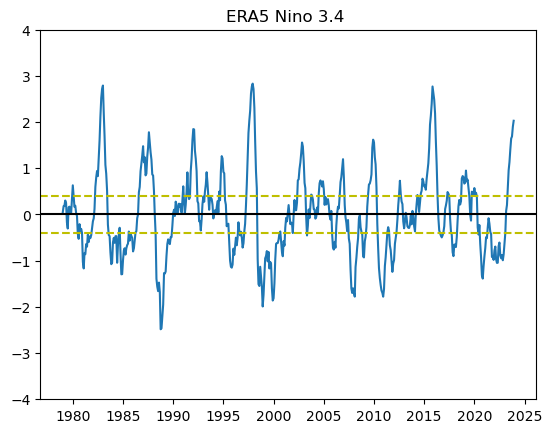

In [50]:
plt.plot(sst_era5_anom.time.values, nino34_era5)
plt.axhline(0,color='k')
plt.axhline(-0.4, color='y',linestyle='--')
plt.axhline(0.4, color='y',linestyle='--')
plt.title('ERA5 Nino 3.4 ')
plt.ylim([-4,4])

In [15]:
## Identify winters that are in different ENSO phases?
#    ENSO active when anomaly +/- 0.4 deg for 6+ months

label_case_ERA5 = np.full([len(sst_era5_anom.time.values)], '---------')

for iTime in range(6, len(sst_era5_anom.time.values)-6):
    # to select the previous six months **including** the current one with np.arange, you need to 
    #   add one the ending number (to be the present iTime), and thus only subtract 5 months 
    this6months_case = sst_era5_anom['nino34'].isel(time=np.arange(iTime-5,iTime+1))

    if (np.all(this6months_case.values>=0.4)):
        label_case_ERA5[iTime] = 'ElNino'
    elif (np.all(this6months_case.values<=-0.4)):
        label_case_ERA5[iTime] = 'LaNina'
    elif ( (np.all(this6months_case.values<-0.4) == False) & (np.all(this6months_case.values>0.4)==False) ):
        label_case_ERA5[iTime] = 'Neutral'



In [16]:
sst_era5_anom['ENSO_phase'] = (('time'), label_case_ERA5)

In [17]:
iElNino_ERA5 = np.where(sst_era5_anom['ENSO_phase'] == 'ElNino')[0]

startInd_ERA5  = iElNino_ERA5[0]
startDate_ERA5 = sst_era5_anom.time.values[iElNino_ERA5[0]]
for iT in range(len(iElNino_ERA5)-1):
    if iElNino_ERA5[iT+1]-iElNino_ERA5[iT]>1:
        print('Start index of new event: ', iElNino_ERA5[iT+1])
        startInd_ERA5  = np.append(startInd_ERA5, iElNino_ERA5[iT+1])
        startDate_ERA5 = np.append(startDate_ERA5, sst_era5_anom.time.values[iElNino_ERA5[iT+1]])
        

Start index of new event:  96
Start index of new event:  158
Start index of new event:  225
Start index of new event:  286
Start index of new event:  311
Start index of new event:  370
Start index of new event:  433
Start index of new event:  482
Start index of new event:  494


In [18]:
prect_era5_latAvg = prect_era5_anom.sel(lat=slice(-5,5)).mean(dim='lat')
sst_era5_latAvg   = sst_era5_anom.sel(lat=slice(-5,5)).mean(dim='lat')
u850_era5_latAvg  = u850_era5_anom.sel(lat=slice(-5,5)).mean(dim='lat')


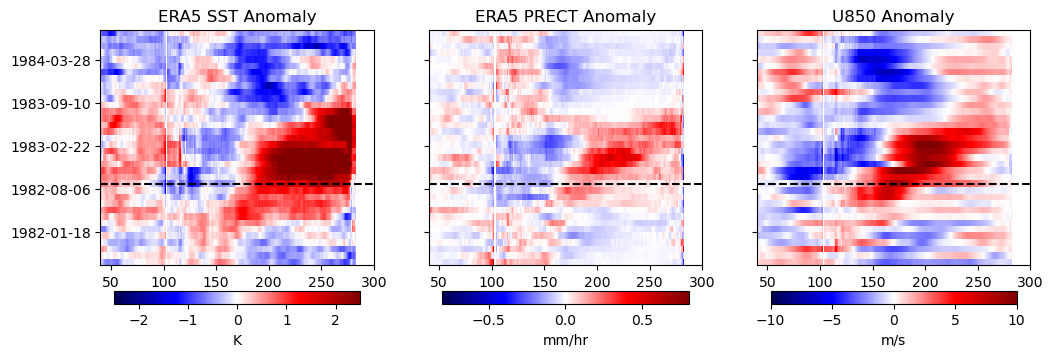

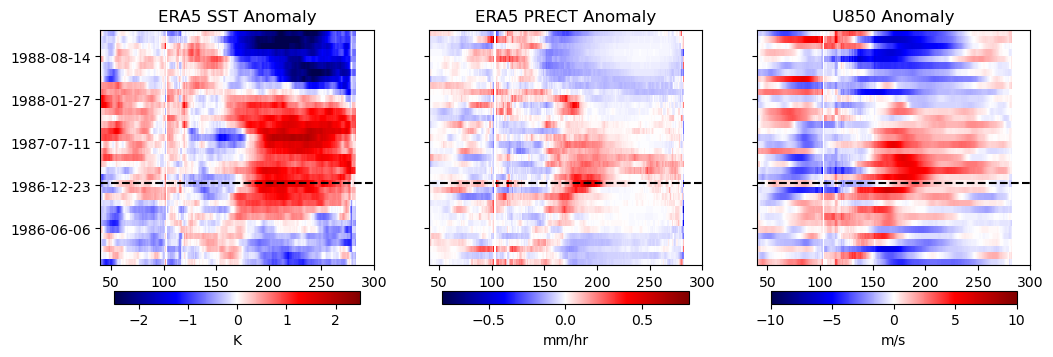

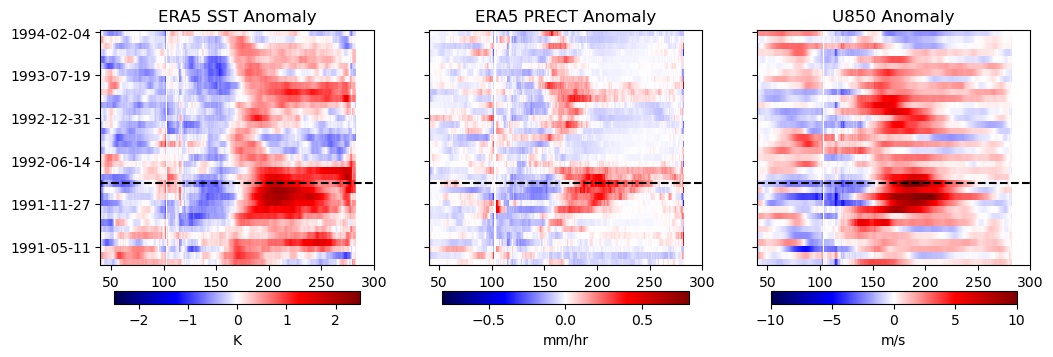

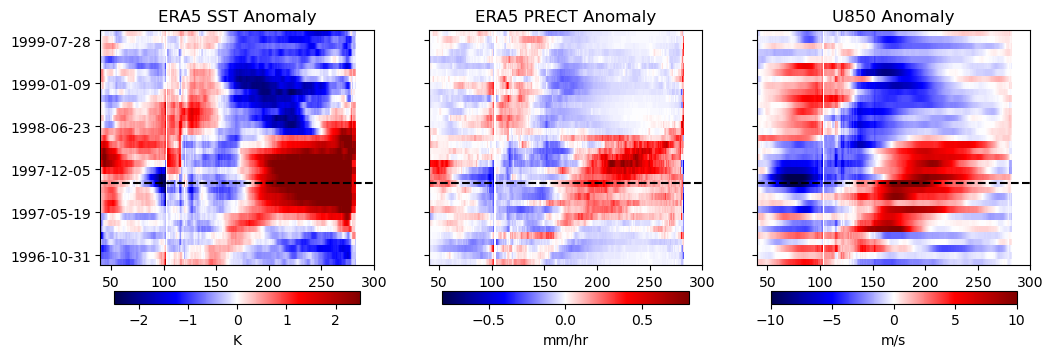

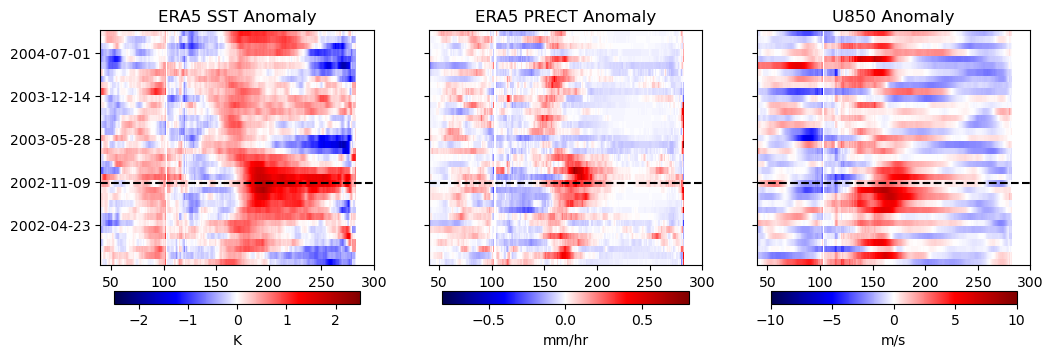

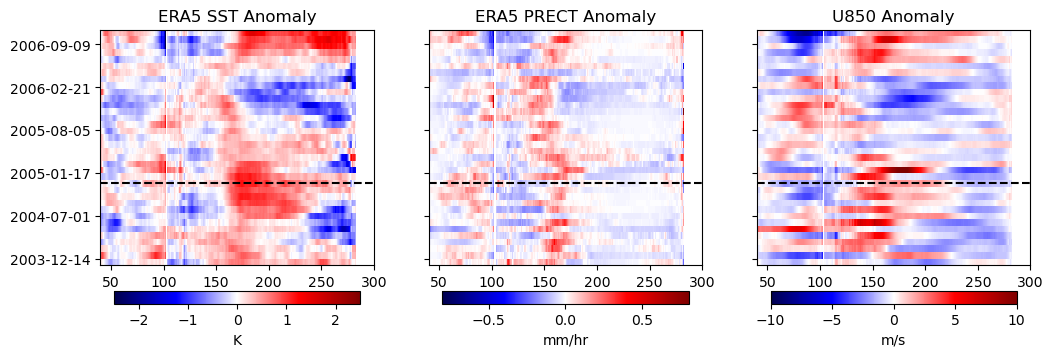

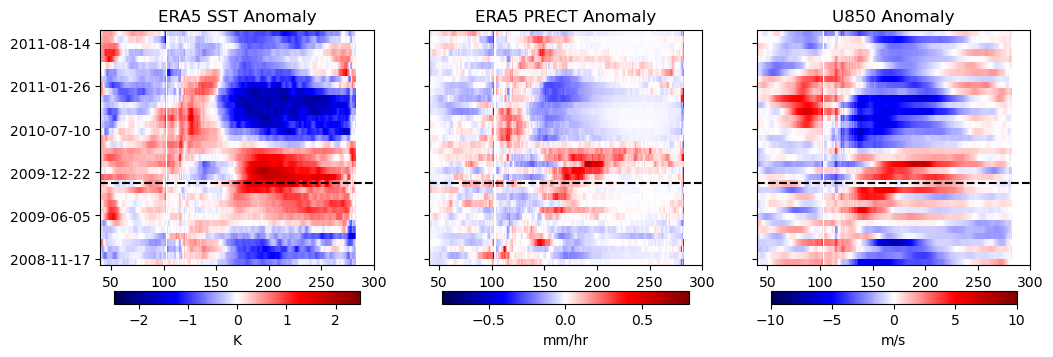

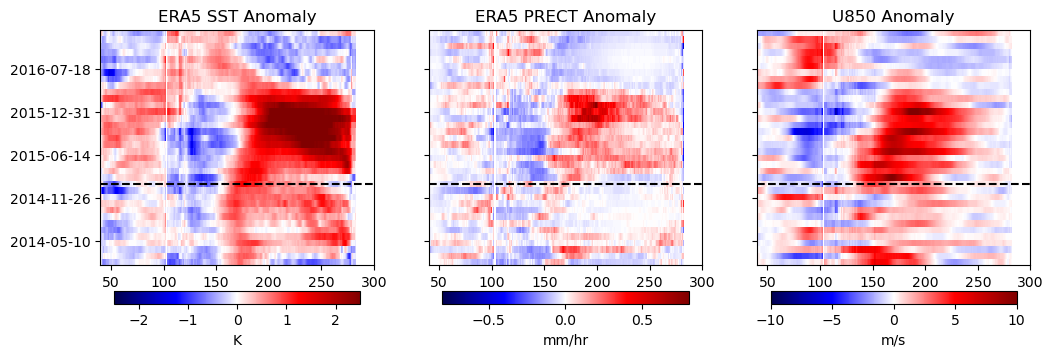

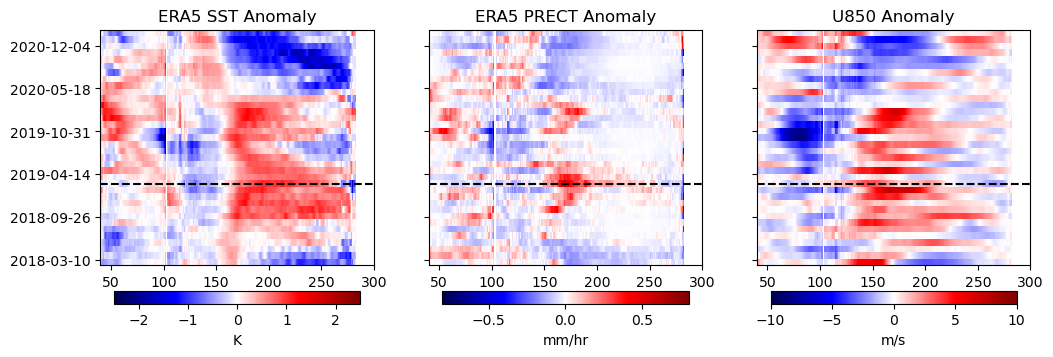

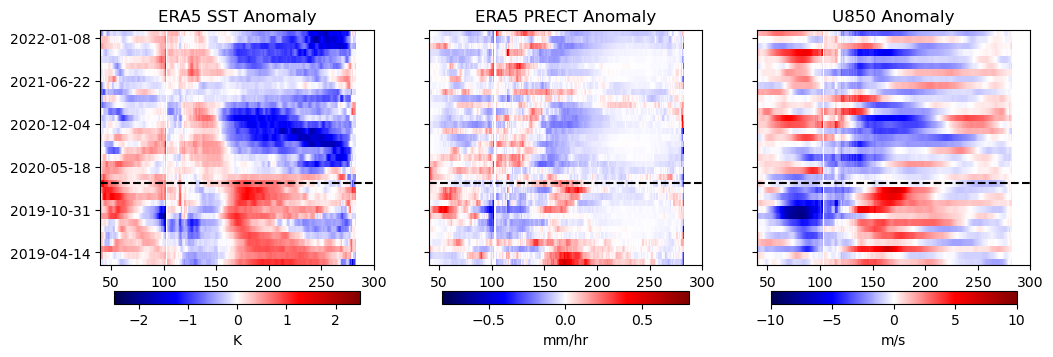

In [21]:

normVar_SST   = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)
normVar_PRECT = matplotlib.colors.Normalize(vmin=-0.8,vmax=0.8)
normVar_U850  = matplotlib.colors.Normalize(vmin=-10,vmax=10)

for iElNino in range(len(startInd_ERA5)): 
    fig,axs=plt.subplots(1,3,figsize=(12,4))
    axs = axs.ravel()

    iStartTime_PRECT = (np.where(prect_era5_anom.time.values==startDate_ERA5[iElNino])[0])[0]
    iStartTime_U850  = (np.where(u850_era5_anom.time.values==startDate_ERA5[iElNino])[0])[0]
    # print(prect_era5_anom.time.values[iStartTime_PRECT])
    
    time_nums      = matplotlib.dates.date2num(sst_era5_latAvg.isel(time=slice(startInd_ERA5[iElNino]-12,(startInd_ERA5[iElNino]+24)))['time'].values)
    longrid,tgrid  = np.meshgrid(sst_era5_latAvg['lon'], time_nums )

    p1 = axs[0].pcolormesh(longrid,tgrid, sst_era5_latAvg.isel(time=slice(startInd_ERA5[iElNino]-12,(startInd_ERA5[iElNino]+24))),
                  norm=normVar_SST, cmap='seismic')
    axs[0].set_title('ERA5 SST Anomaly')
    axs[0].yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d')) 

    p2 = axs[1].pcolormesh(longrid, tgrid, prect_era5_latAvg.isel(time=slice(iStartTime_PRECT-12,(iStartTime_PRECT+24))),
                  norm=normVar_PRECT, cmap='seismic')
    axs[1].set_title('ERA5 PRECT Anomaly')
    axs[1].set_yticklabels([])

    p3 = axs[2].pcolormesh(longrid,tgrid, u850_era5_latAvg.isel(time=slice(iStartTime_U850-12,(iStartTime_U850+24))),
                  norm=normVar_U850, cmap='seismic')
    axs[2].set_title('U850 Anomaly')
    axs[2].set_yticklabels([])
    
    [a.set_xlim([40,300]) for a in axs]
    startDateNum =  matplotlib.dates.date2num(sst_era5_latAvg.isel(time=startInd_ERA5[iElNino])['time'].values)
    [a.axhline(startDateNum, color='k', linestyle='--')  for a in axs]
    # [a.yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d')) for a in axs]
    
    # Add Colorbars
    cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_SST, cmap='seismic'), ax=axs[0], 
                       shrink=0.9, label='K', orientation='horizontal', pad=0.085) 
    cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_PRECT, cmap='seismic'), ax=axs[1], 
                       shrink=0.9, label='mm/hr', orientation='horizontal', pad=0.085) 
    cb3 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_U850, cmap='seismic'), ax=axs[2], 
                       shrink=0.9, label='m/s', orientation='horizontal', pad=0.085)

    fig.savefig('Figures/Hovs/ERA5_ENSOvars_hov_startDate'+str(sst_era5_latAvg.isel(time=startInd_ERA5[iElNino])['time.year'].values)+str(sst_era5_latAvg.isel(time=startInd_ERA5[iElNino])['time.month'].values)+'.jpg')


## CESM3 runs

In [22]:

listFiles_TS = np.asarray((
      [ 
       '/glade/derecho/scratch/mdfowler/enso_wavelet/b.e30_beta04.BLT1850.ne30_t232_wgx3.121.cam.h0a.TS.60-156.10.N-10.S.nc',    
      ]))



In [23]:
for iSim in range(len(listFiles_TS)):
# for iSim in range(3):
    DS = xr.open_dataset(listFiles_TS[iSim]) 
    if DS['time.day'].isel(time=0).values==1:
        DS = cesm_correct_time(DS)
    else: 
        print('First day in file is ', DS.time.values[0])

    # Remove first year of each simulation
    timeOffset = DS.time.values[0]  + timedelta(days=365)
    iKeep      = np.where(DS.time.values>=timeOffset)[0]
    DS         = DS.isel(time=iKeep)

    startYear = DS.isel(time=0)['time.year'].values
    endYear   = DS.isel(time=-1)['time.year'].values
    
    ## Add case ID (short name) to the DS
    #x = re.search("BLT1850.ne30_t232.", listFiles_TS[iSim])
    ## Add case ID (short name) to the DS
    caseName = listFiles_TS[iSim].split(".")[4] 
    #print(caseName)
    #if x:
    #    caseName = listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]
    #else: 
    #    x = re.search("BLTHIST.ne30_t232.", listFiles_TS[iSim])
    #    caseName = 'HIST_'+listFiles_TS[iSim][x.span()[-1]:4+x.span()[-1]]

    if caseName=='112':
        # iSelTimes = np.where((DS['time.year'].values>=6) & (DS['time.year'].values<=50) )[0]
        # iSelTimes = np.where((DS['time.year'].values>=6) )[0]
        iSelTimes = np.where((DS['time.year'].values>=2) )[0]
        DS = DS.isel(time=iSelTimes).copy()
        startYear = DS.isel(time=0)['time.year'].values
        endYear   = DS.isel(time=-1)['time.year'].values
        
    
    ocnMask = DS.LANDFRAC.values
    ocnMask[ocnMask>0.45] = np.nan
    ocnMask[ocnMask<=0.45] = 1
    
    # Detrend data 
    TS = DS.TS 
    ts = signal.detrend(TS, axis=0, type='linear')
    # Get SST 
    sst = ts * ocnMask
    
    sst = xr.DataArray(sst, 
        coords={'time': DS.time.values,
                'lat':  DS.lat.values, 
                'lon':  DS.lon.values}, 
        dims=["time", "lat", "lon"])
    
    # Remove annual cycle from monthly data 
    sst_anom = rmMonAnnCyc(sst)
    
    ## Compute nino 3.4 index
    ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
    ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]
    
    # # Compute weights and get Nino3.4 
    regionTS = sst_anom.isel(lat=ilats, lon=ilons)
    coswgt   = np.cos(np.deg2rad(regionTS.lat))
    nino34     = regionTS.weighted(coswgt).mean(('lon','lat'))

First day in file is  0060-01-16 12:00:00


In [24]:
DS['nino34'] = (('time'), nino34.values)

Text(0.5, 1.0, 'Run 121 Nino 3.4')

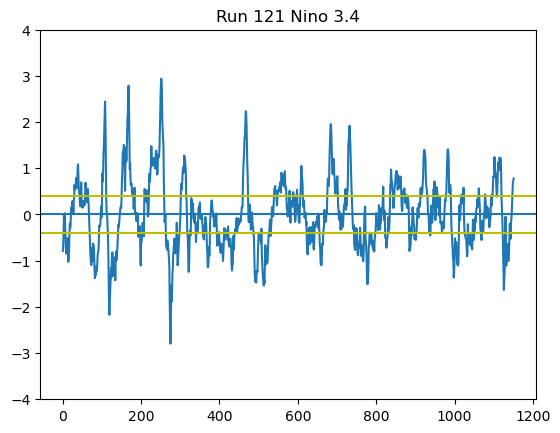

In [58]:

plt.plot(nino34)
plt.axhline(0)
plt.axhline(0.4,color='y')
plt.axhline(-0.4,color='y')
plt.ylim([-4,4])
plt.title('Run 121 Nino 3.4')
# plt.axvline(200,color='r')
# plt.axvline(400,color='r')

### Identify events

In [26]:
## Identify winters that are in different ENSO phases?
#    ENSO active when anomaly +/- 0.4 deg for 6+ months

label_case = np.full([len(DS.time.values)], '---------')

for iTime in range(6, len(DS.time.values)-6):
    # to select the previous six months **including** the current one with np.arange, you need to 
    #   add one the ending number (to be the present iTime), and thus only subtract 5 months 
    this6months_case = DS['nino34'].isel(time=np.arange(iTime-5,iTime+1))

    if (np.all(this6months_case.values>=0.4)):
        label_case[iTime] = 'ElNino'
    elif (np.all(this6months_case.values<=-0.4)):
        label_case[iTime] = 'LaNina'
    elif ( (np.all(this6months_case.values<-0.4) == False) & (np.all(this6months_case.values>0.4)==False) ):
        label_case[iTime] = 'Neutral'


In [27]:
DS['ENSO_phase'] = (('time'), label_case)

In [28]:
iElNino = np.where(DS['ENSO_phase'] == 'ElNino')[0]

startInd = iElNino[0] 
for iT in range(len(iElNino)-1):
    if iElNino[iT+1]-iElNino[iT]>1:
        print('Start index of new event: ', iElNino[iT+1])
        startInd = np.append(startInd, iElNino[iT+1])
        

Start index of new event:  106
Start index of new event:  156
Start index of new event:  225
Start index of new event:  307
Start index of new event:  465
Start index of new event:  545
Start index of new event:  554
Start index of new event:  612
Start index of new event:  681
Start index of new event:  731
Start index of new event:  841
Start index of new event:  852
Start index of new event:  873
Start index of new event:  921
Start index of new event:  983
Start index of new event:  1103
Start index of new event:  1114


In [29]:
sst_latAvg = sst_anom.sel(lat=slice(-5,5)).mean(dim='lat')

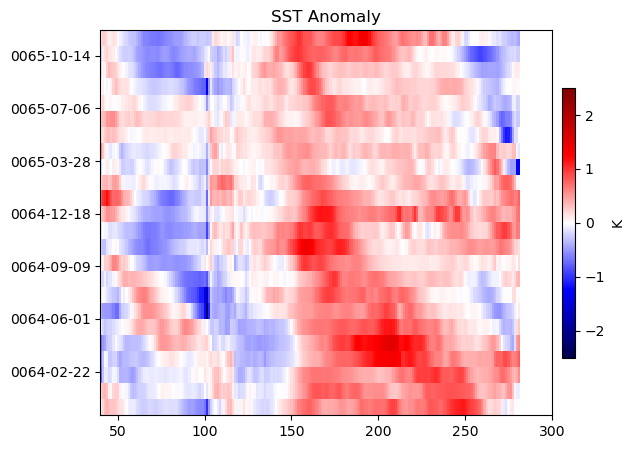

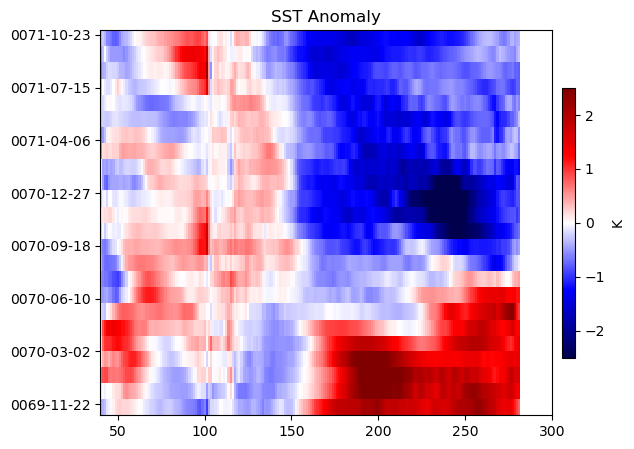

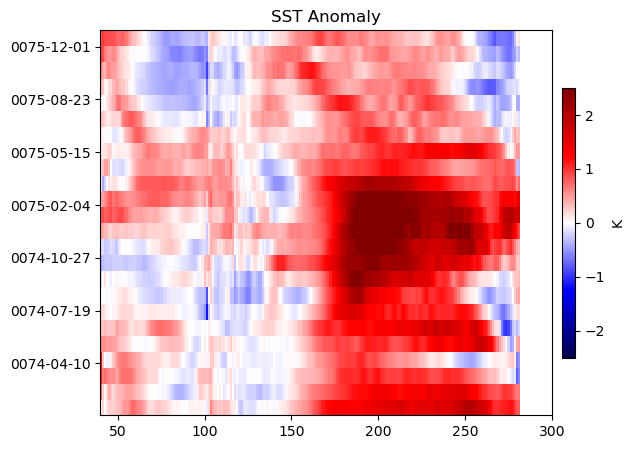

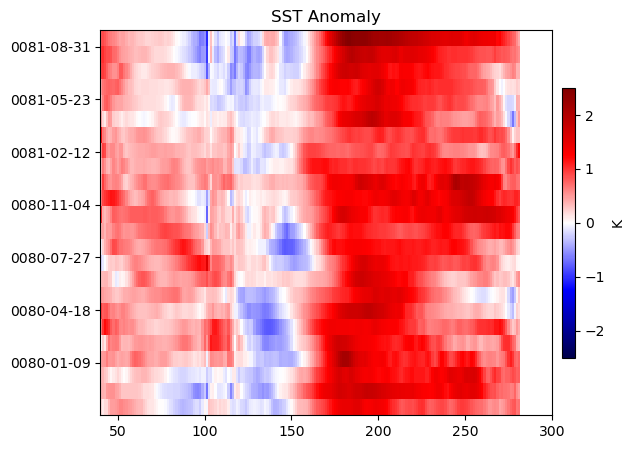

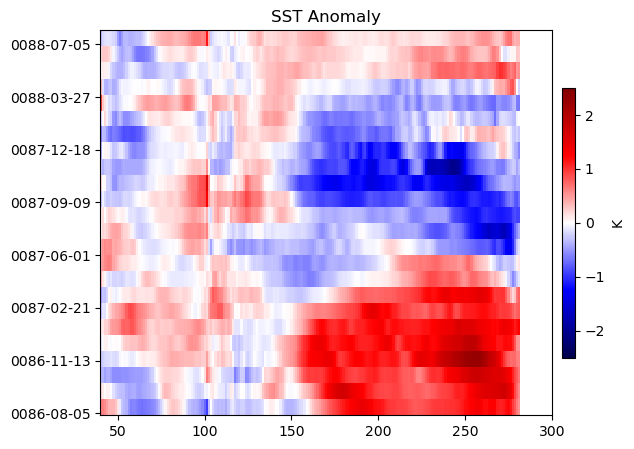

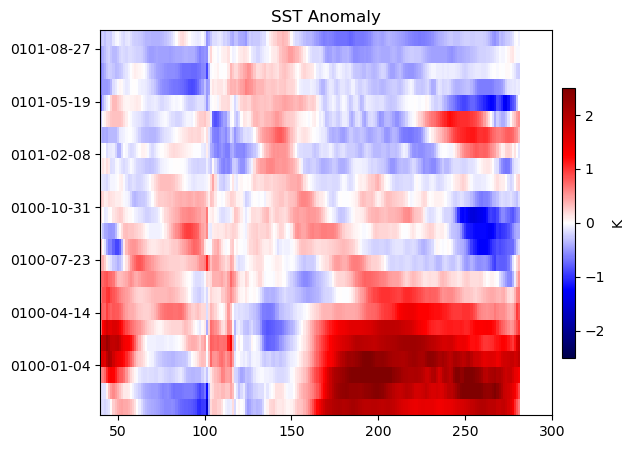

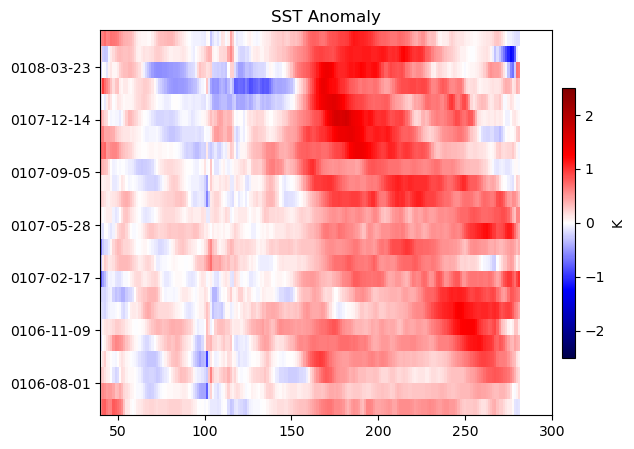

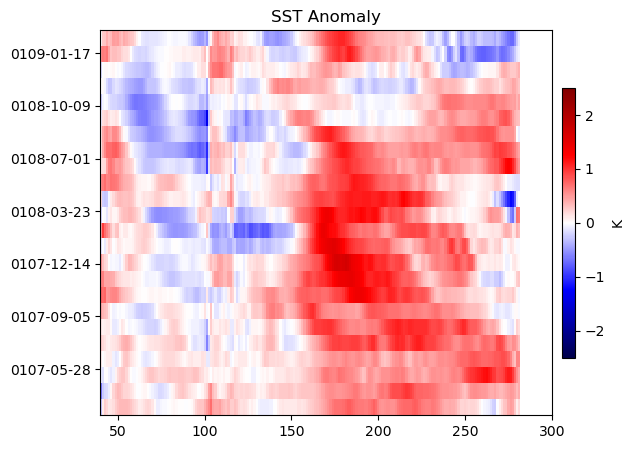

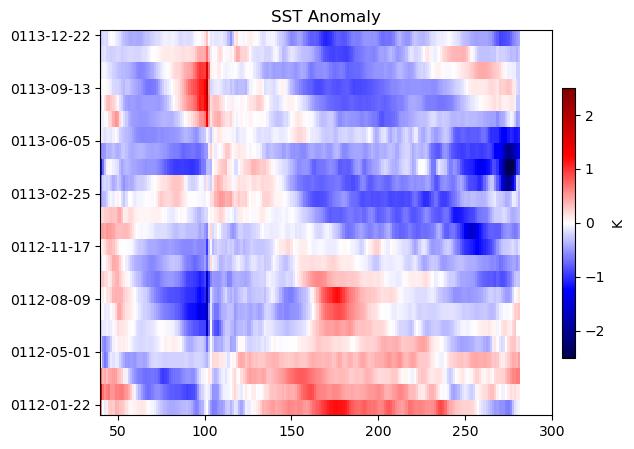

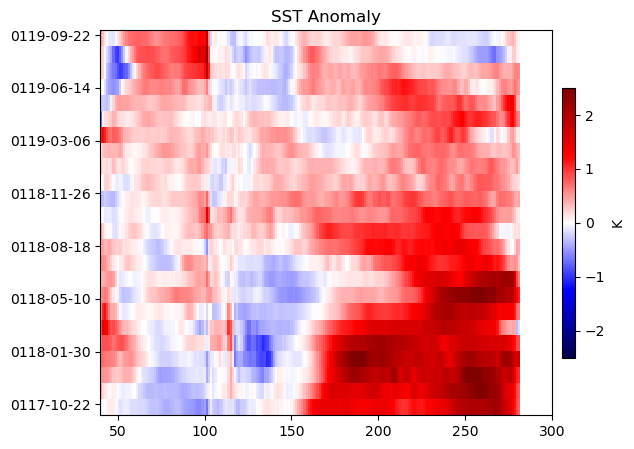

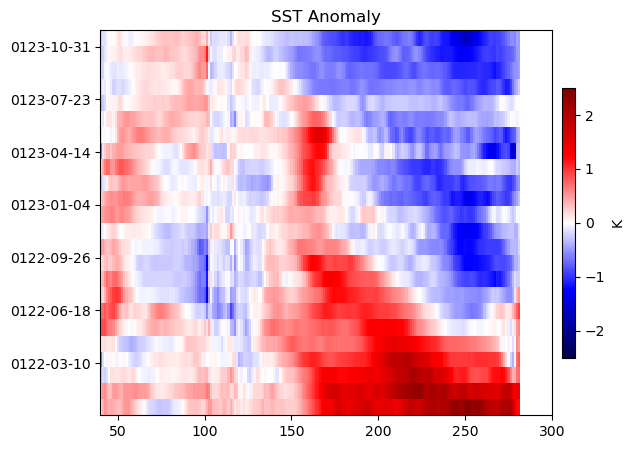

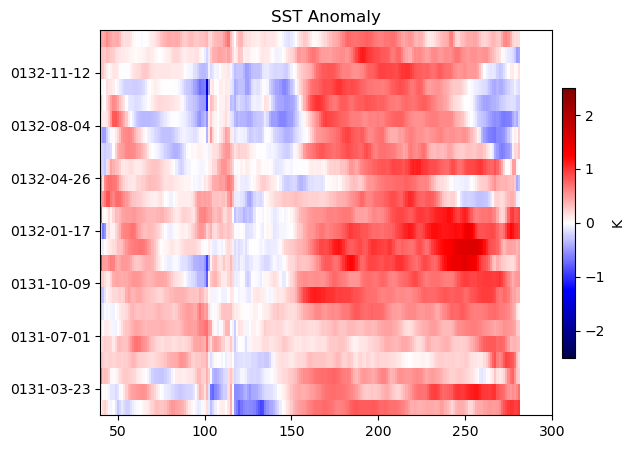

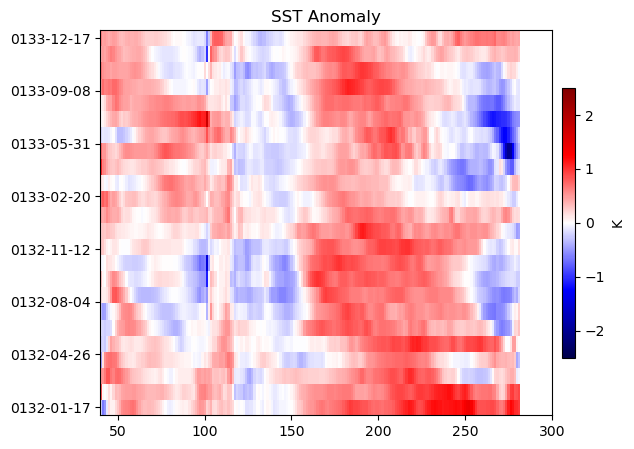

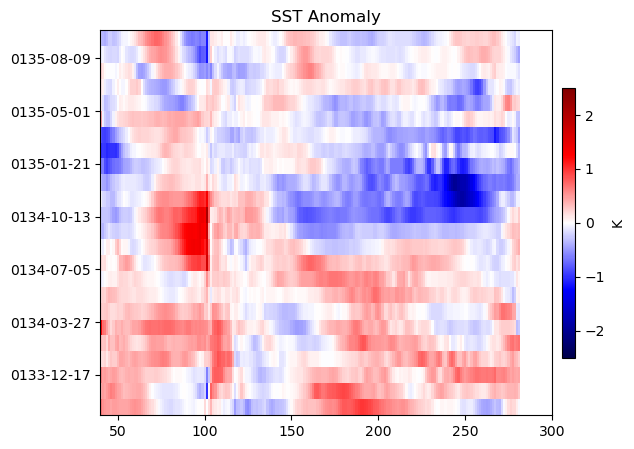

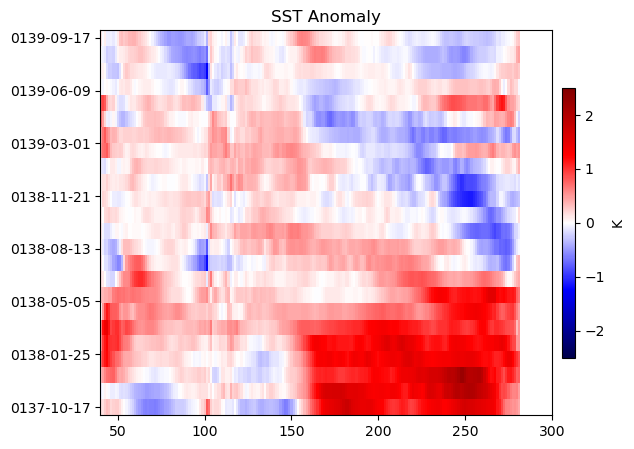

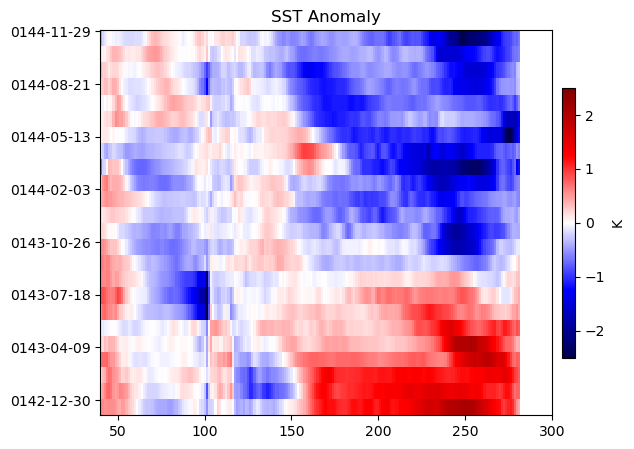

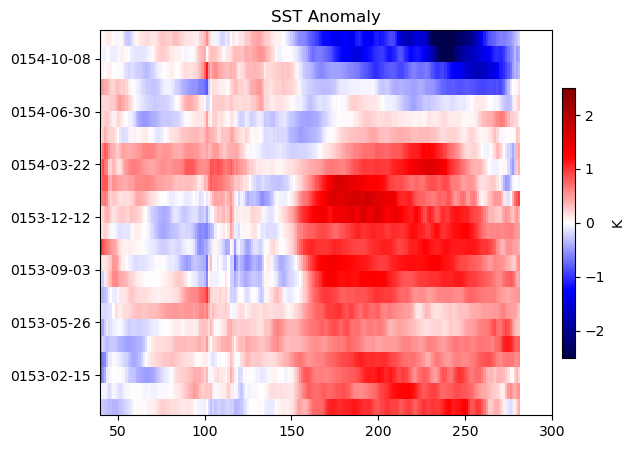

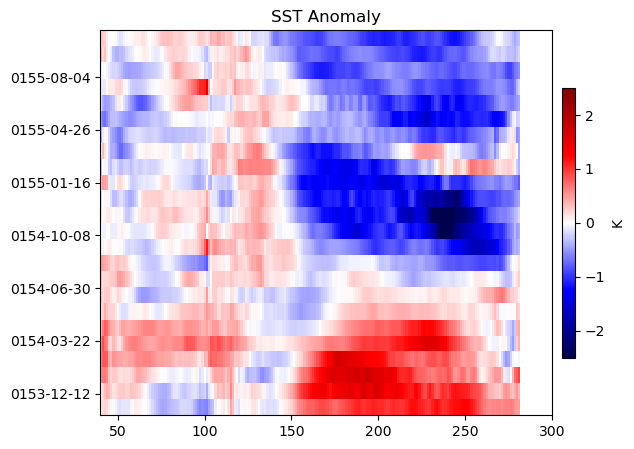

In [30]:
longrid,tgrid  = np.meshgrid(sst_latAvg['lon'], sst_latAvg['time'] )

normVar = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)

for iElNino in range(len(startInd)): 
    fig,axs=plt.subplots(1,1,figsize=(7,5))

    time_nums = matplotlib.dates.date2num(sst_latAvg.isel(time=slice(startInd[iElNino],(startInd[iElNino]+24)))['time'].values)

    longrid,tgrid  = np.meshgrid(sst_latAvg['lon'], time_nums)

    p1 = axs.pcolormesh(longrid,tgrid, sst_latAvg.isel(time=slice(startInd[iElNino],(startInd[iElNino]+24))).values,
                  norm=normVar, cmap='seismic')
    axs.set_title('SST Anomaly')
    axs.set_xlim([40,300])
    axs.yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d'))


    # Add Colorbar
    cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar, cmap='seismic'), ax=axs, 
                       shrink=0.7, label='K', orientation='vertical', pad=0.018) 

## Read in more than just TS; get some variables from montly h0 files in CAM 

In [31]:
dataDir = '/glade/derecho/scratch/hannay/archive/b.e30_beta04.BLT1850.ne30_t232_wgx3.121/atm/hist/'
listFiles = np.sort(glob.glob(dataDir+'*.h0a.*.nc'))
listFiles = listFiles[(60*12):(156*12)]
len(listFiles)


1152

In [32]:
def preprocess_h0(DS):
    climoVar_list = ['LHFLX','SHFLX','LWCF','SWCF','PRECT','PS','TAUX','TAUY','TGCLDLWP','U10','TREFHT','UBOT']

    dsSel = DS.sel(lat=slice(-10,10))
    u850  = DS.sel(lev=850, method='nearest').U
    dsSel = dsSel[climoVar_list]
    dsSel['U850'] = u850
    
    return dsSel

In [33]:
camDS = xr.open_mfdataset(listFiles, preprocess=preprocess_h0, concat_dim='time', combine='nested', 
                                 decode_times=True, data_vars='minimal', parallel=True)


In [34]:
if len(DS.time.values)==len(camDS.time.values):
    print('Start time (SST DS): ', DS.time.values[0])
    print('End time (SST DS):   ', DS.time.values[-1])
    print('\nStart time (h0 DS):  ', camDS.time.values[0])
    print('End time (h0 DS):    ', camDS.time.values[-1])
else: 
    print('Possible Error')


Start time (SST DS):  0061-01-16 12:00:00
End time (SST DS):    0156-12-16 12:00:00

Start time (h0 DS):   0061-01-16 12:00:00
End time (h0 DS):     0156-12-16 12:00:00


In [35]:
## Compute anomalies 

# Detrend data 
PRECT = camDS.PRECT * 3.6e6 # Units convert to mm/hr (from m/s) 
prect_detrend = signal.detrend(PRECT, axis=0, type='linear')

TAUX = camDS.TAUX 
taux_detrend = signal.detrend(TAUX, axis=0, type='linear')

U850 = camDS.U850 
u850_detrend = signal.detrend(U850, axis=0, type='linear')

LHFLX = camDS.LHFLX 
lhflx_detrend = signal.detrend(LHFLX, axis=0, type='linear')

# Get ocean values only 
prect = prect_detrend * ocnMask
taux  = taux_detrend * ocnMask
u850  = u850_detrend * ocnMask
lhflx = lhflx_detrend * ocnMask

# Also remove annual cycle
prect = xr.DataArray(prect, 
    coords={'time': camDS.time.values,
            'lat':  camDS.lat.values, 
            'lon':  camDS.lon.values}, 
    dims=["time", "lat", "lon"])

taux = xr.DataArray(taux, 
    coords={'time': camDS.time.values,
            'lat':  camDS.lat.values, 
            'lon':  camDS.lon.values}, 
    dims=["time", "lat", "lon"])

u850 = xr.DataArray(u850, 
    coords={'time': camDS.time.values,
            'lat':  camDS.lat.values, 
            'lon':  camDS.lon.values}, 
    dims=["time", "lat", "lon"])

lhflx = xr.DataArray(lhflx, 
    coords={'time': camDS.time.values,
            'lat':  camDS.lat.values, 
            'lon':  camDS.lon.values}, 
    dims=["time", "lat", "lon"])

prect_anom = rmMonAnnCyc(prect)
taux_anom  = rmMonAnnCyc(taux)
u850_anom   = rmMonAnnCyc(u850)
lhflx_anom = rmMonAnnCyc(lhflx)


In [36]:
## Get ready to make Hovmoller plots
camDS['ENSO_phase'] = (('time'), label_case)

prect_latAvg = prect_anom.sel(lat=slice(-5,5)).mean(dim='lat')
taux_latAvg  = taux_anom.sel(lat=slice(-5,5)).mean(dim='lat')
u850_latAvg  = u850_anom.sel(lat=slice(-5,5)).mean(dim='lat')
lhflx_latAvg = lhflx_anom.sel(lat=slice(-5,5)).mean(dim='lat')


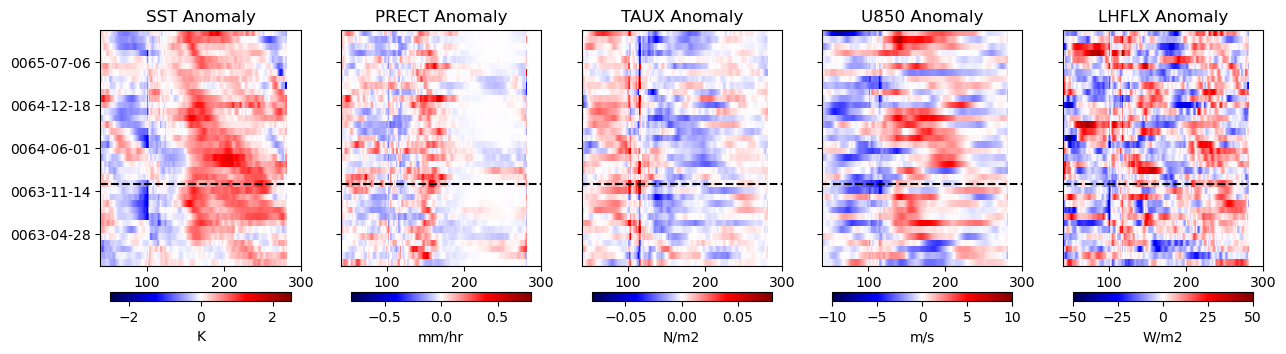

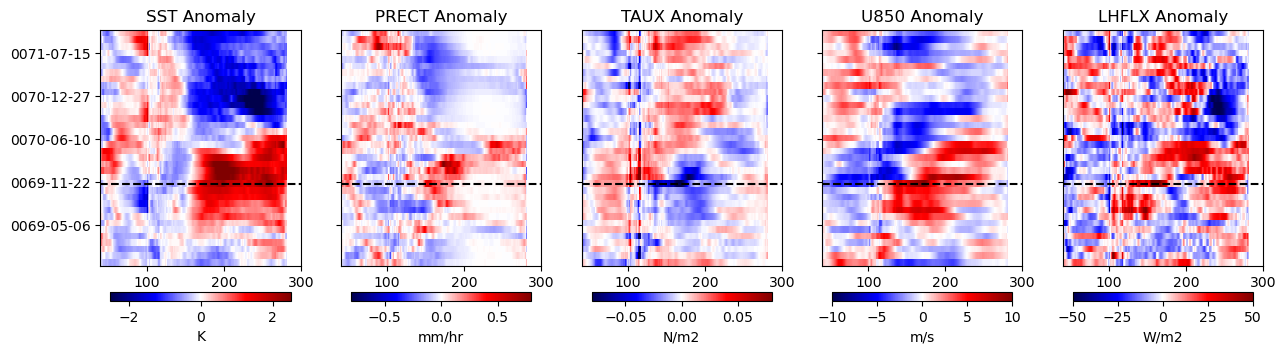

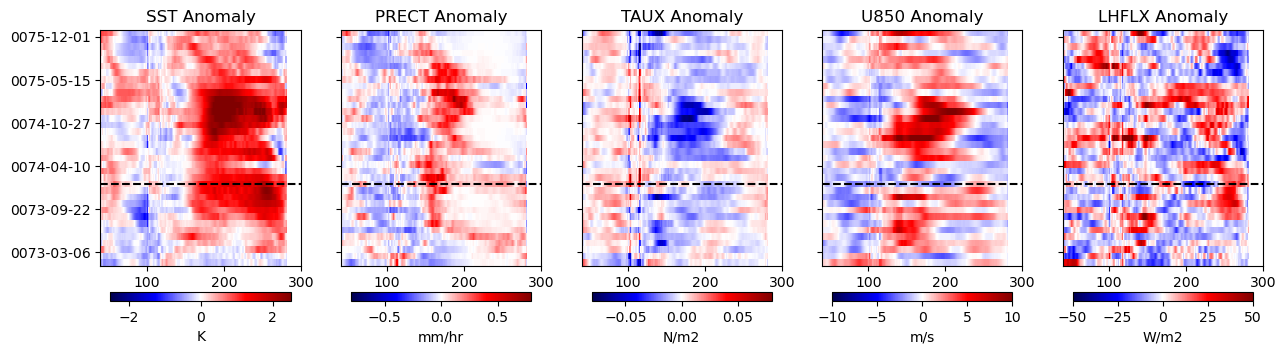

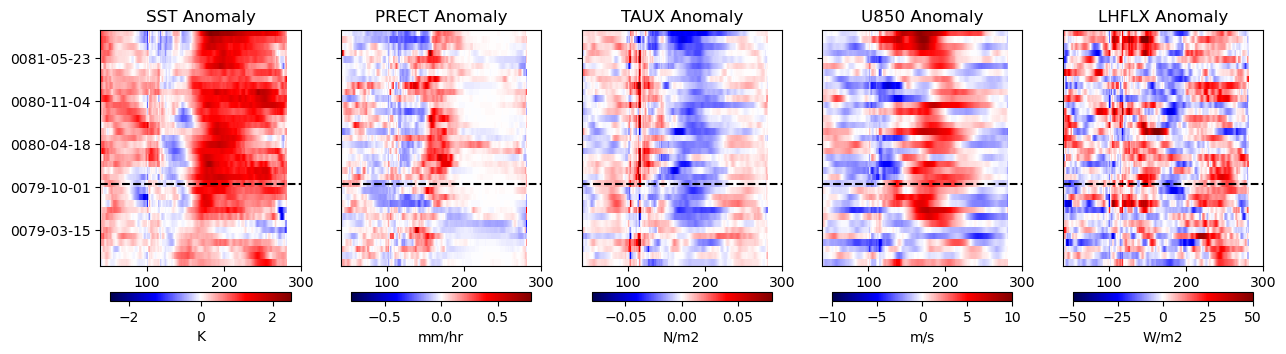

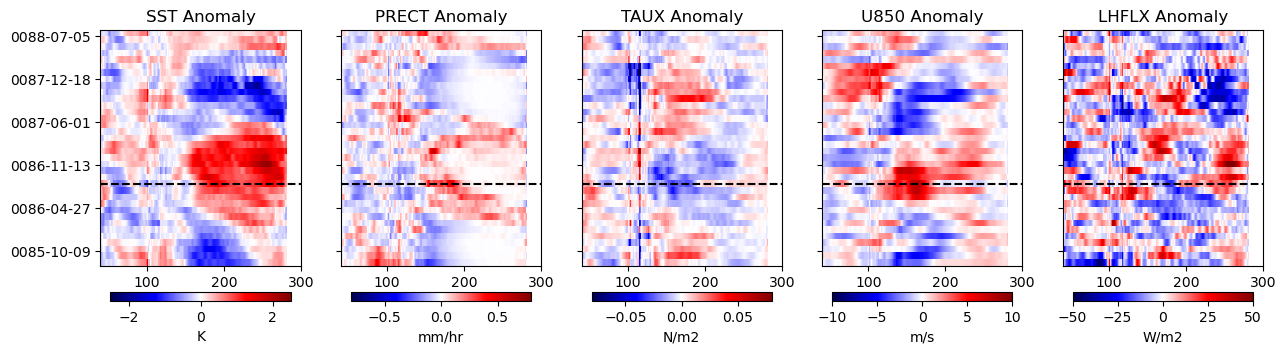

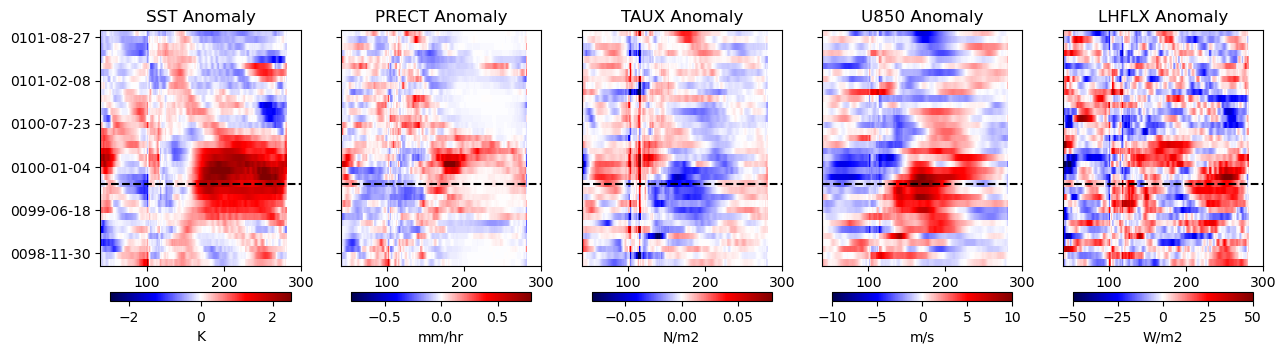

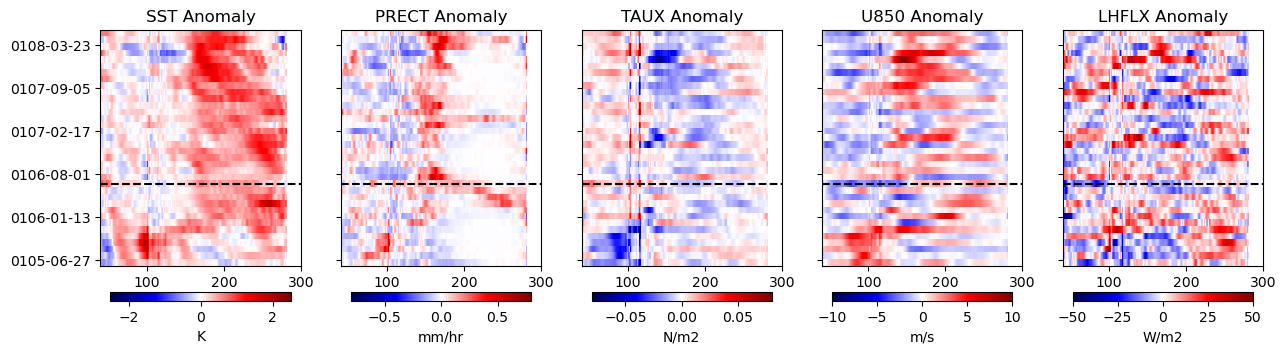

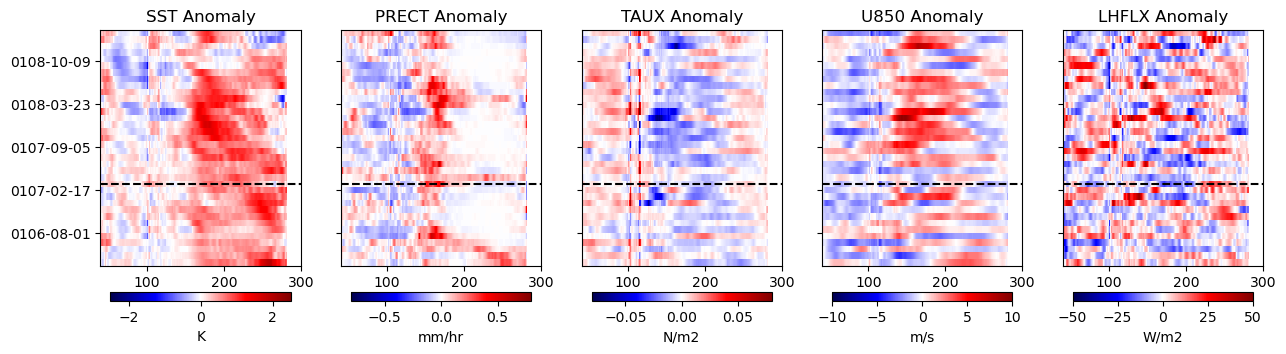

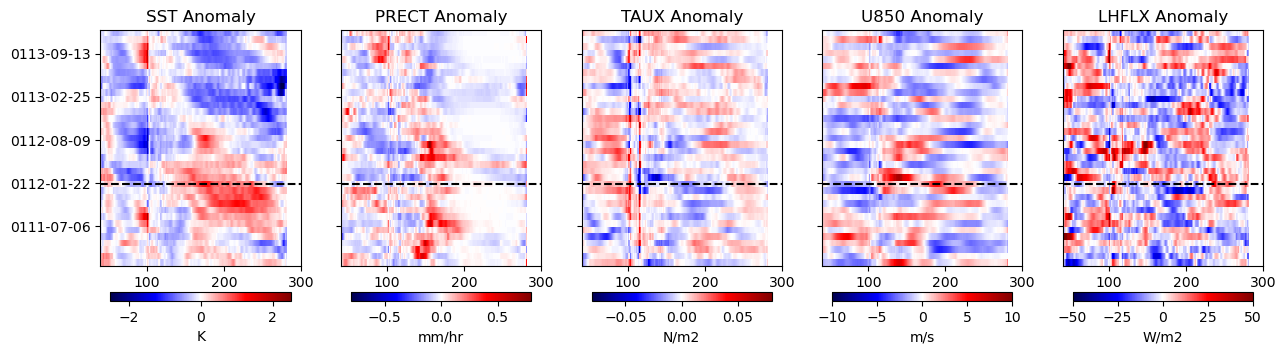

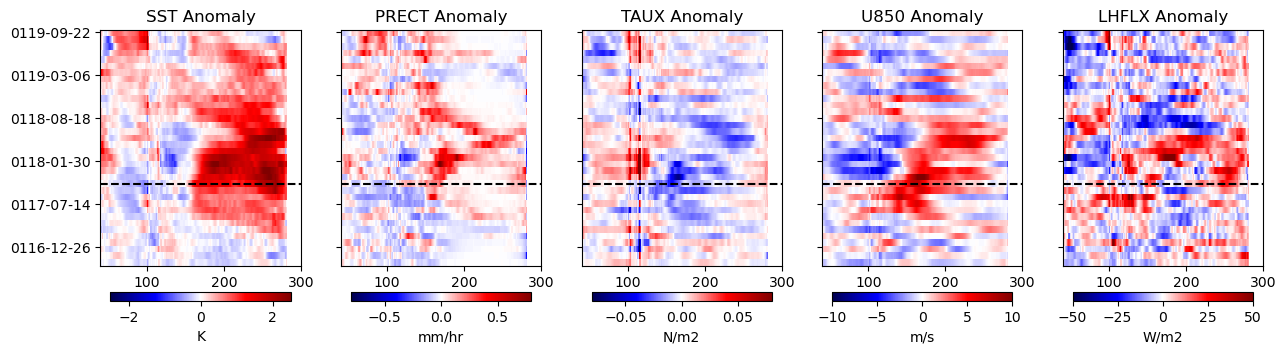

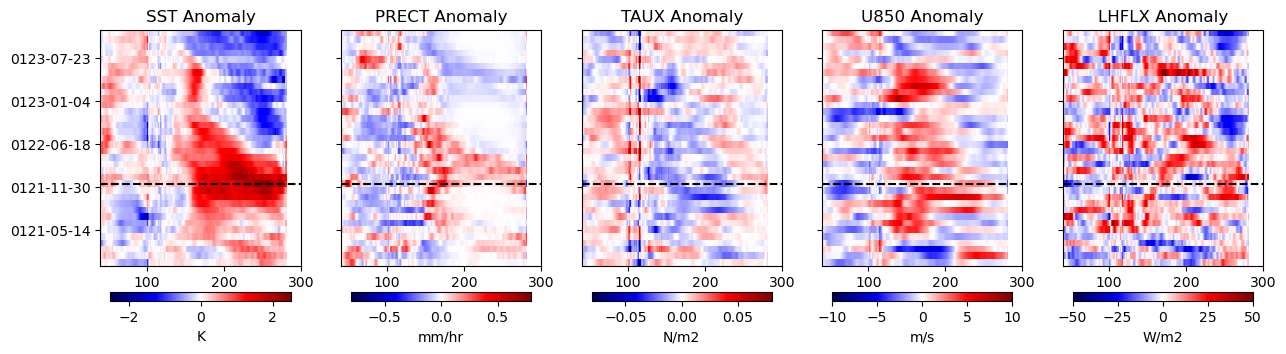

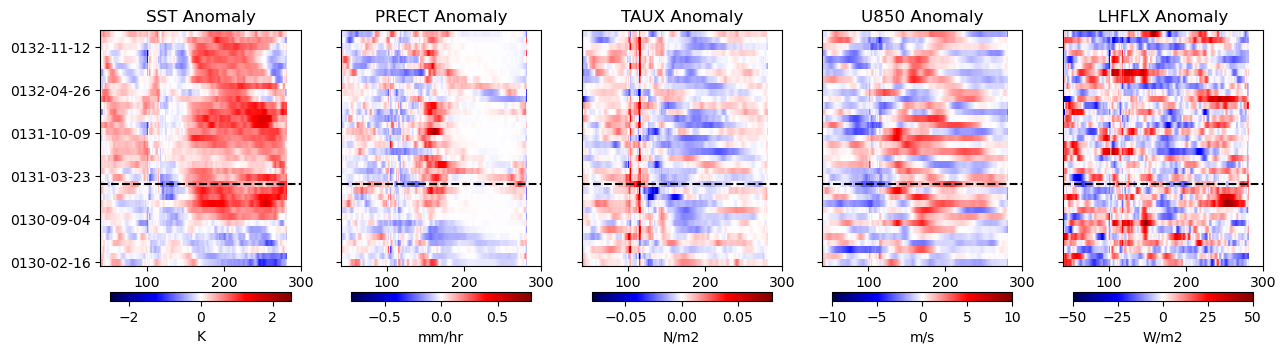

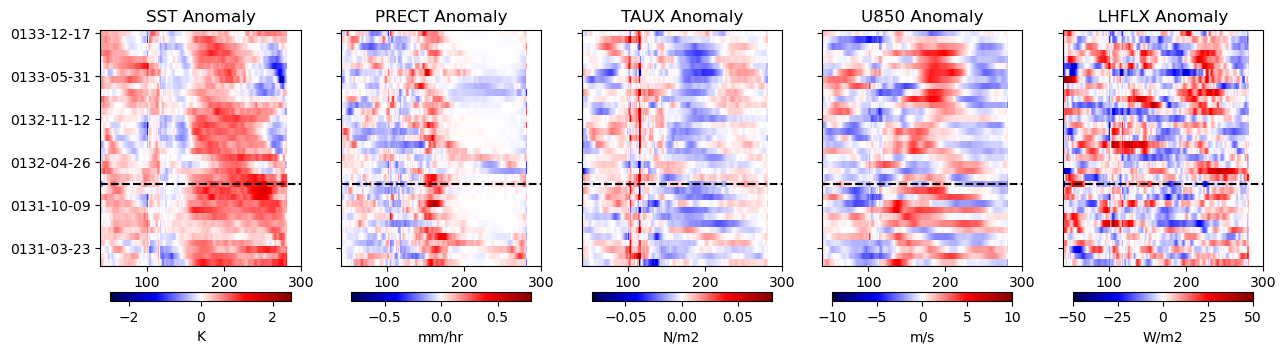

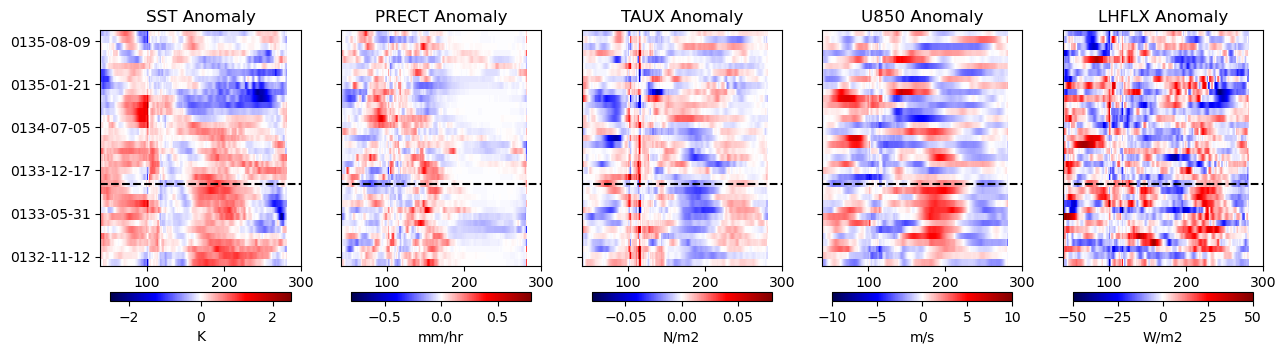

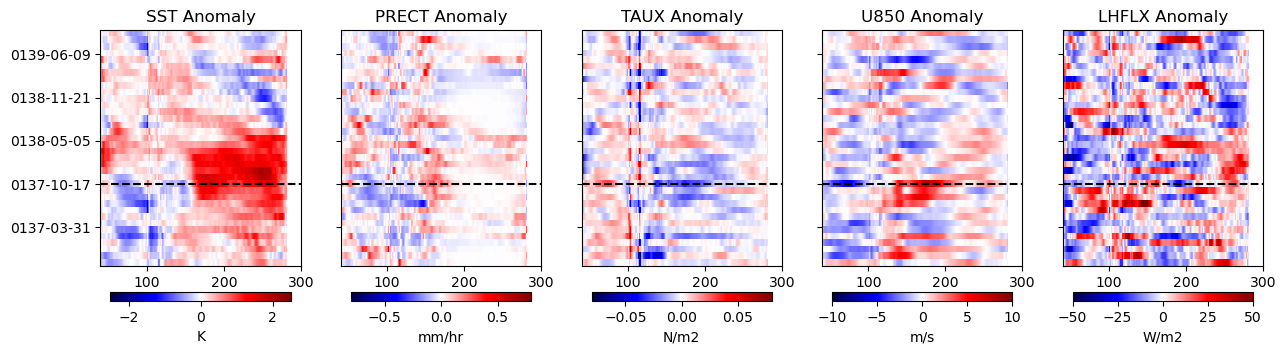

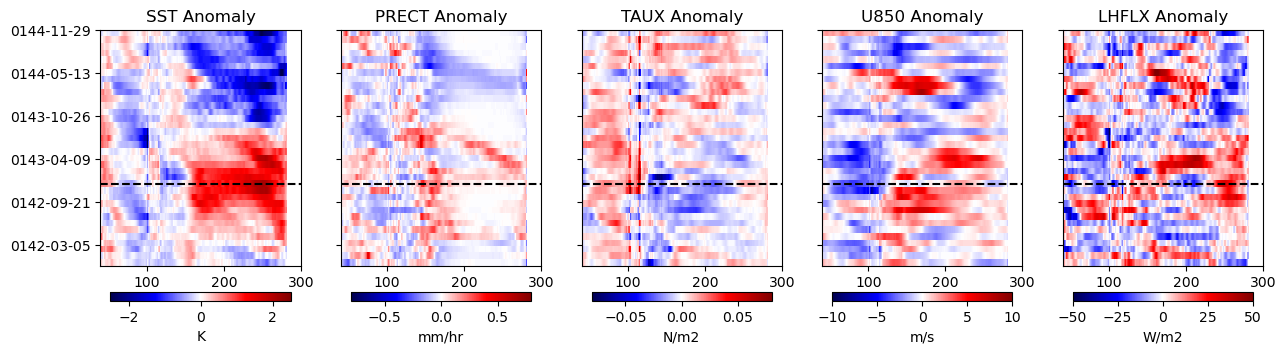

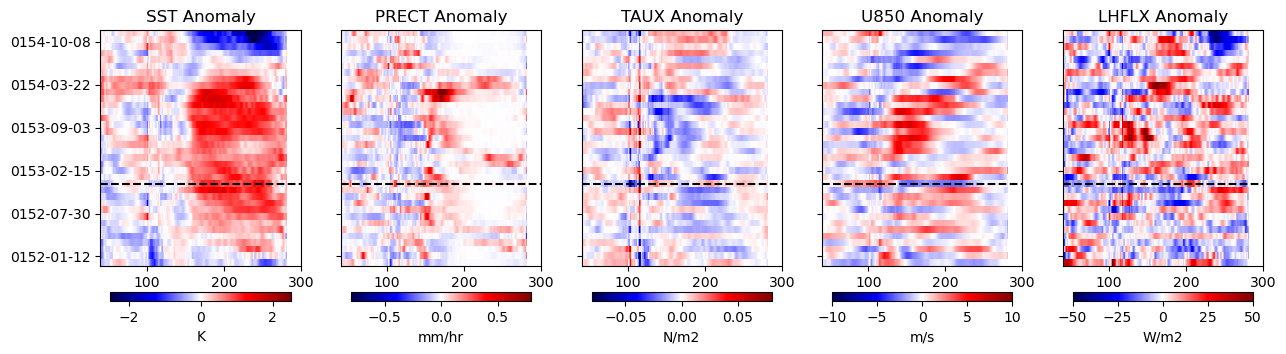

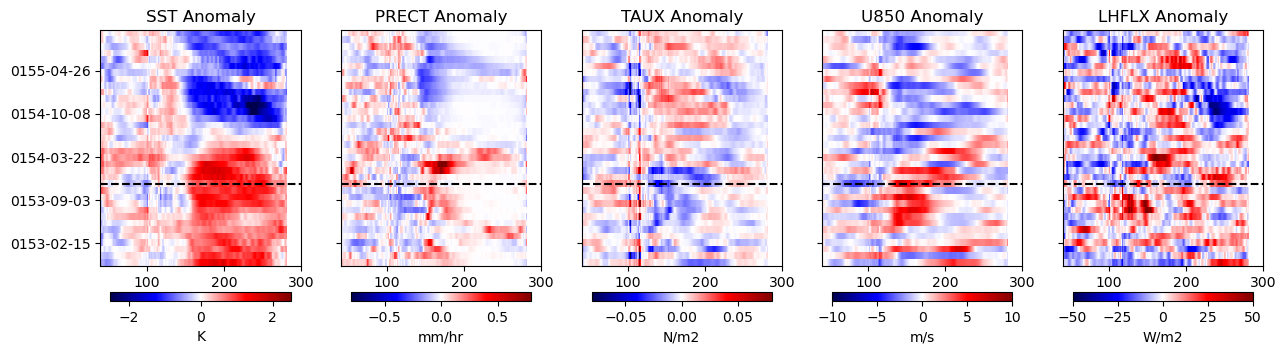

In [37]:

normVar_SST   = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)
normVar_TAUX  = matplotlib.colors.Normalize(vmin=-0.08,vmax=0.08)
normVar_PRECT = matplotlib.colors.Normalize(vmin=-0.8,vmax=0.8)
normVar_U850  = matplotlib.colors.Normalize(vmin=-10,vmax=10)
normVar_LHFLX = matplotlib.colors.Normalize(vmin=-50,vmax=50)

for iElNino in range(len(startInd)): 
    fig,axs=plt.subplots(1,5,figsize=(15,4))
    axs = axs.ravel()

    time_nums = matplotlib.dates.date2num(sst_latAvg.isel(time=slice(startInd[iElNino]-12,(startInd[iElNino]+24)))['time'].values)
    longrid,tgrid  = np.meshgrid(sst_latAvg['lon'], time_nums )

    p1 = axs[0].pcolormesh(longrid,tgrid, sst_latAvg.isel(time=slice(startInd[iElNino]-12,(startInd[iElNino]+24))),
                  norm=normVar_SST, cmap='seismic')
    axs[0].set_title('SST Anomaly')
    axs[0].yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d')) 

    p2 = axs[1].pcolormesh(longrid,tgrid, prect_latAvg.isel(time=slice(startInd[iElNino]-12,(startInd[iElNino]+24))),
                  norm=normVar_PRECT, cmap='seismic')
    axs[1].set_title('PRECT Anomaly')
    axs[1].set_yticklabels([])

    p3 = axs[2].pcolormesh(longrid,tgrid, taux_latAvg.isel(time=slice(startInd[iElNino]-12,(startInd[iElNino]+24))),
                  norm=normVar_TAUX, cmap='seismic')
    axs[2].set_title('TAUX Anomaly')
    axs[2].set_yticklabels([])

    p4 = axs[3].pcolormesh(longrid,tgrid, u850_latAvg.isel(time=slice(startInd[iElNino]-12,(startInd[iElNino]+24))),
                  norm=normVar_U850, cmap='seismic')
    axs[3].set_title('U850 Anomaly')
    axs[3].set_yticklabels([])

    p5 = axs[4].pcolormesh(longrid,tgrid, lhflx_latAvg.isel(time=slice(startInd[iElNino]-12,(startInd[iElNino]+24))),
                  norm=normVar_LHFLX, cmap='seismic')
    axs[4].set_title('LHFLX Anomaly')
    axs[4].set_yticklabels([])
    
    
    [a.set_xlim([40,300]) for a in axs]
    startDateNum =  matplotlib.dates.date2num(sst_latAvg.isel(time=startInd[iElNino])['time'].values)
    [a.axhline(startDateNum, color='k', linestyle='--')  for a in axs]
    # [a.yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d')) for a in axs]
    
    # Add Colorbars
    cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_SST, cmap='seismic'), ax=axs[0], 
                       shrink=0.9, label='K', orientation='horizontal', pad=0.085) 
    cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_PRECT, cmap='seismic'), ax=axs[1], 
                       shrink=0.9, label='mm/hr', orientation='horizontal', pad=0.085) 
    cb3 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_TAUX, cmap='seismic'), ax=axs[2], 
                       shrink=0.9, label='N/m2', orientation='horizontal', pad=0.085)
    cb4 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_U850, cmap='seismic'), ax=axs[3], 
                       shrink=0.9, label='m/s', orientation='horizontal', pad=0.085)
    cb5 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_LHFLX, cmap='seismic'), ax=axs[4], 
                       shrink=0.9, label='W/m2', orientation='horizontal', pad=0.085)

    fig.savefig('Figures/Hovs/ENSOvars_hov_startDate'+str(sst_latAvg.isel(time=startInd[iElNino])['time.year'].values)+str(sst_latAvg.isel(time=startInd[iElNino])['time.month'].values)+'.jpg')


## Get CESM2 data

In [85]:
yearRange = '0500'

cesm2_dir      = '/glade/campaign/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/'
listFiles_ts   = np.sort(glob.glob(cesm2_dir+'ts/gn/files/d20190320/'+'ts_Amon_CESM2_piControl_r1i1p1f1_gn*'+yearRange+'*.nc'))[0]
listFiles_ua   = np.sort(glob.glob(cesm2_dir+'ua/gn/files/d20190320/'+'ua_Amon_CESM2_piControl_r1i1p1f1_gn*'+yearRange+'*.nc'))[0]
listFiles_pr   = np.sort(glob.glob(cesm2_dir+'pr/gn/files/d20190320/'+'pr_Amon_CESM2_piControl_r1i1p1f1_gn*'+yearRange+'*.nc'))[0]
listFiles_tauu = np.sort(glob.glob(cesm2_dir+'tauu/gn/files/d20190320/'+'tauu_Amon_CESM2_piControl_r1i1p1f1_gn*'+yearRange+'*.nc'))[0]


# Open datasets and pick out equator piece/correct times 
cesm2_sst = xr.open_dataset(listFiles_ts, decode_times=False)
cesm2_sst = preprocess(cesm2_sst)

cesm2_u850 = xr.open_dataset(listFiles_ua, decode_times=False)
cesm2_u850 = cesm2_u850.sel(plev=85000.0, method='nearest')
cesm2_u850 = preprocess(cesm2_u850)

cesm2_pr = xr.open_dataset(listFiles_pr, decode_times=False)
cesm2_pr = preprocess(cesm2_pr)

cesm2_taux = xr.open_dataset(listFiles_tauu, decode_times=False)
cesm2_taux = preprocess(cesm2_taux)



/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'ua' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tauu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [86]:
cesm2_ocnMask = ocnMask[0,:,:]
cesm2_ocnMask = np.repeat(cesm2_ocnMask[np.newaxis, :, :], len(cesm2_sst.time.values), axis=0)


In [87]:
## Compute anomalies

# Detrend data 
SST = cesm2_sst.ts.values
##   This is a little wonky because signal.detrend can't handle NaNs so replacing with a marker that we mask later
sst_detrend = signal.detrend(SST, axis=0, type='linear')

PRECT = cesm2_pr.pr 
prect_detrend = signal.detrend(PRECT, axis=0, type='linear')

U850 = cesm2_u850.ua
##   This is a little wonky because signal.detrend can't handle NaNs so replacing with a marker that we mask later
u850_Fill = U850.values
u850_Fill[(np.isnan(u850_Fill))] = -99
u850_detrend = signal.detrend(u850_Fill, axis=0, type='linear')

TAUX = cesm2_taux.tauu
taux_detrend = signal.detrend(TAUX, axis=0, type='linear')


# Get ocean values only 
cesm2_prect = prect_detrend * cesm2_ocnMask
cesm2_sst   = sst_detrend * cesm2_ocnMask
cesm2_u850  = u850_detrend * cesm2_ocnMask
cesm2_taux  = taux_detrend * cesm2_ocnMask

# Also remove annual cycle
cesm2_sst = xr.DataArray(cesm2_sst, 
    coords={'time': cesm2_pr.time.values,
            'lat':  cesm2_pr.lat.values, 
            'lon':  cesm2_pr.lon.values}, 
    dims=["time", "lat", "lon"])

cesm2_prect = xr.DataArray(cesm2_prect, 
    coords={'time': cesm2_pr.time.values,
            'lat':  cesm2_pr.lat.values, 
            'lon':  cesm2_pr.lon.values}, 
    dims=["time", "lat", "lon"])


cesm2_u850 = xr.DataArray(cesm2_u850, 
    coords={'time': cesm2_pr.time.values,
            'lat':  cesm2_pr.lat.values, 
            'lon':  cesm2_pr.lon.values}, 
    dims=["time", "lat", "lon"])

cesm2_taux = xr.DataArray(cesm2_taux, 
    coords={'time': cesm2_pr.time.values,
            'lat':  cesm2_pr.lat.values, 
            'lon':  cesm2_pr.lon.values}, 
    dims=["time", "lat", "lon"])


sst_cesm2_anom   = rmMonAnnCyc(cesm2_sst)
prect_cesm2_anom = rmMonAnnCyc(cesm2_prect)
u850_cesm2_anom  = rmMonAnnCyc(cesm2_u850)
taux_cesm2_anom  = rmMonAnnCyc(cesm2_taux)


In [88]:
## Compute nino 3.4 index
ilats = np.where((sst_cesm2_anom.lat.values>=lat_s34)  & (sst_cesm2_anom.lat.values<=lat_n34))[0]
ilons = np.where((sst_cesm2_anom.lon.values>=lon_e34)  & (sst_cesm2_anom.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTS    = sst_cesm2_anom.isel(lat=ilats, lon=ilons)
coswgt      = np.cos(np.deg2rad(regionTS.lat))
nino34_cesm2 = regionTS.weighted(coswgt).mean(('lon','lat'))


In [89]:
sst_cesm2_anom['nino34'] = (('time'), nino34_cesm2.values)

(-4.0, 4.0)

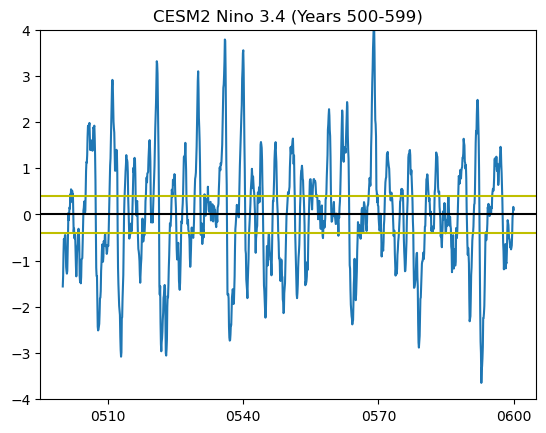

In [90]:
plt.plot(sst_cesm2_anom.time.values, sst_cesm2_anom.nino34)
plt.axhline(0,color='k')
plt.axhline(0.4,color='y')
plt.axhline(-0.4,color='y')
plt.title('CESM2 Nino 3.4 (Years '+str(nino34_cesm2['time.year'].values[0])+'-'+str(nino34_cesm2['time.year'].values[-1])+')')
plt.ylim([-4,4])

In [95]:
## Identify winters that are in different ENSO phases?
#    ENSO active when anomaly +/- 0.4 deg for 6+ months

label_case_cesm2 = np.full([len(sst_cesm2_anom.time.values)], '---------')

for iTime in range(6, len(sst_cesm2_anom.time.values)-6):
    # to select the previous six months **including** the current one with np.arange, you need to 
    #   add one the ending number (to be the present iTime), and thus only subtract 5 months 
    this6months_case = sst_cesm2_anom['nino34'].isel(time=np.arange(iTime-5,iTime+1))

    if (np.all(this6months_case.values>=0.4)):
        label_case_cesm2[iTime] = 'ElNino'
    elif (np.all(this6months_case.values<=-0.4)):
        label_case_cesm2[iTime] = 'LaNina'
    elif ( (np.all(this6months_case.values<-0.4) == False) & (np.all(this6months_case.values>0.4)==False) ):
        label_case_cesm2[iTime] = 'Neutral'



In [96]:
sst_cesm2_anom['ENSO_phase'] = (('time'), label_case_cesm2)

In [97]:
iElNino_cesm2 = np.where(sst_cesm2_anom['ENSO_phase'] == 'ElNino')[0]

startInd_cesm2   = iElNino_cesm2[0]
startDate_cesm2 = sst_cesm2_anom.time.values[iElNino_ERA5[0]]
for iT in range(len(iElNino_cesm2)-1):
    if iElNino_cesm2[iT+1]-iElNino_cesm2[iT]>1:
        print('Start index of new event: ', iElNino_cesm2[iT+1])
        startInd_cesm2  = np.append(startInd_cesm2, iElNino_cesm2[iT+1])
        startDate_cesm2 = np.append(startDate_cesm2, sst_cesm2_anom.time.values[iElNino_cesm2[iT+1]])
        

Start index of new event:  130
Start index of new event:  170
Start index of new event:  192
Start index of new event:  227
Start index of new event:  247
Start index of new event:  298
Start index of new event:  325
Start index of new event:  356
Start index of new event:  420
Start index of new event:  475
Start index of new event:  505
Start index of new event:  529
Start index of new event:  566
Start index of new event:  604
Start index of new event:  638
Start index of new event:  670
Start index of new event:  706
Start index of new event:  743
Start index of new event:  819
Start index of new event:  862
Start index of new event:  923
Start index of new event:  971
Start index of new event:  994
Start index of new event:  1057
Start index of new event:  1101
Start index of new event:  1147


In [98]:
prect_cesm2_latAvg = prect_cesm2_anom.sel(lat=slice(-5,5)).mean(dim='lat')
sst_cesm2_latAvg   = sst_cesm2_anom.sel(lat=slice(-5,5)).mean(dim='lat')
u850_cesm2_latAvg  = u850_cesm2_anom.sel(lat=slice(-5,5)).mean(dim='lat')
taux_cesm2_latAvg  = taux_cesm2_anom.sel(lat=slice(-5,5)).mean(dim='lat')


In [99]:
prect_cesm2_latAvg.max()

<xarray.DataArray ()>
array(0.00039027)

/glade/derecho/scratch/mdfowler/tmp/ipykernel_11436/1564346792.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(1,4,figsize=(15,4))


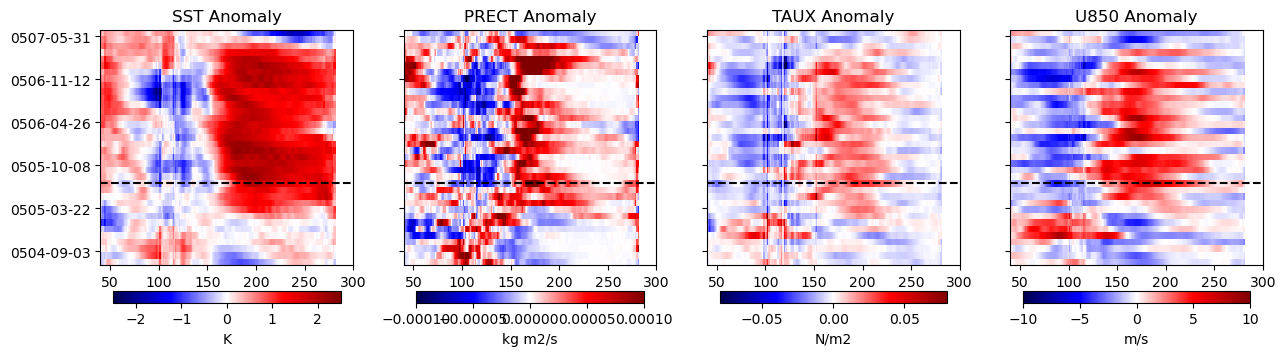

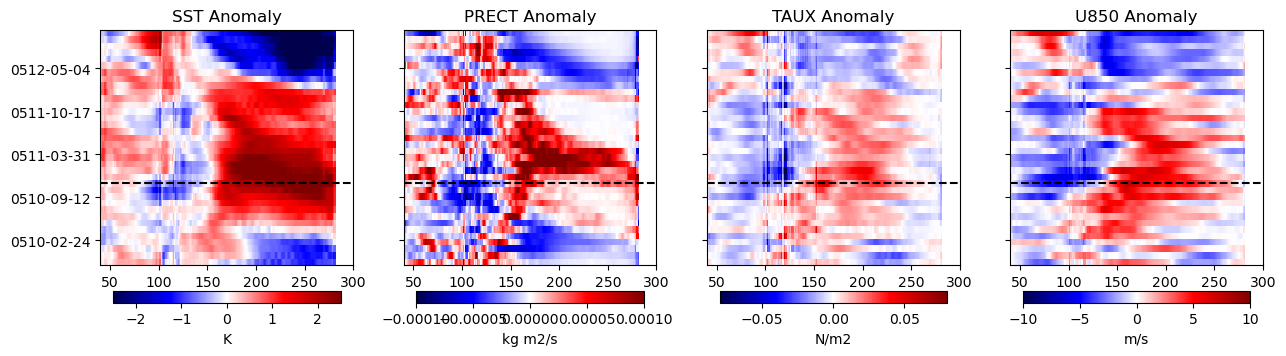

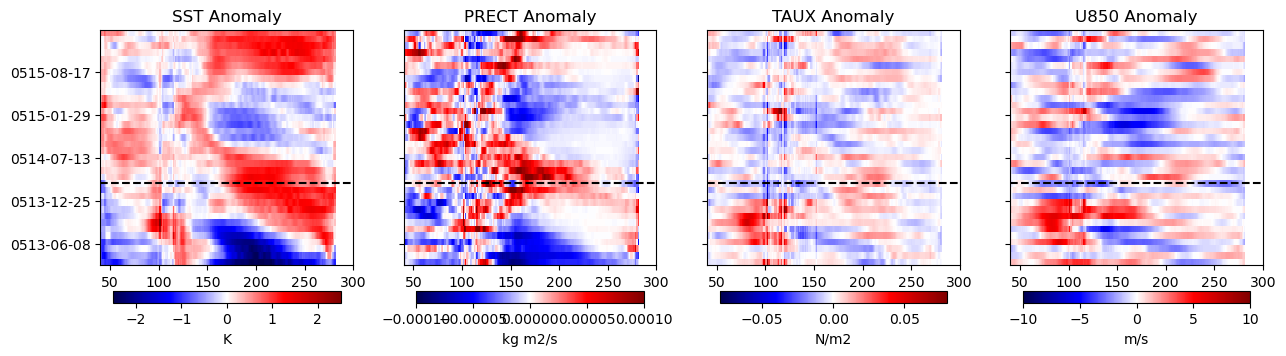

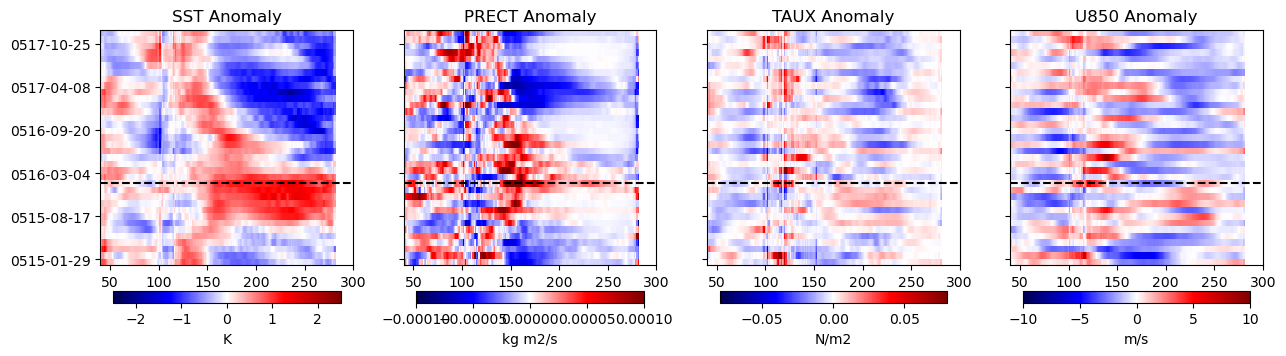

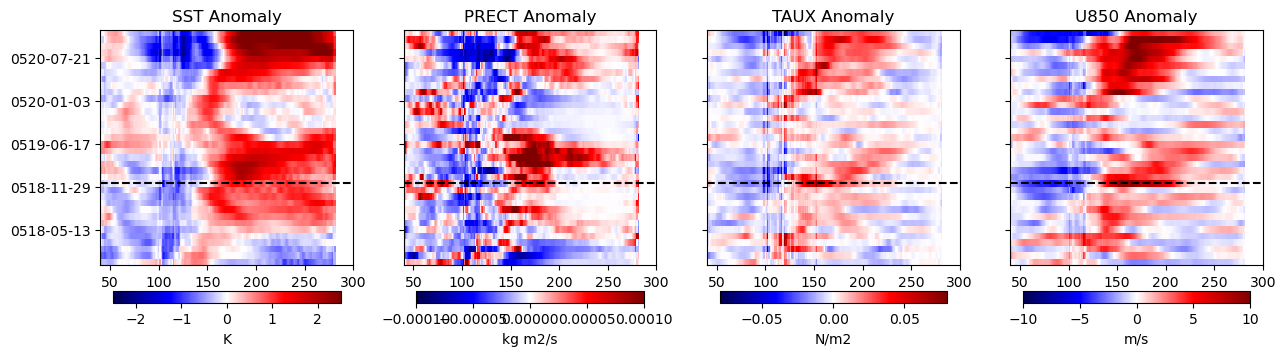

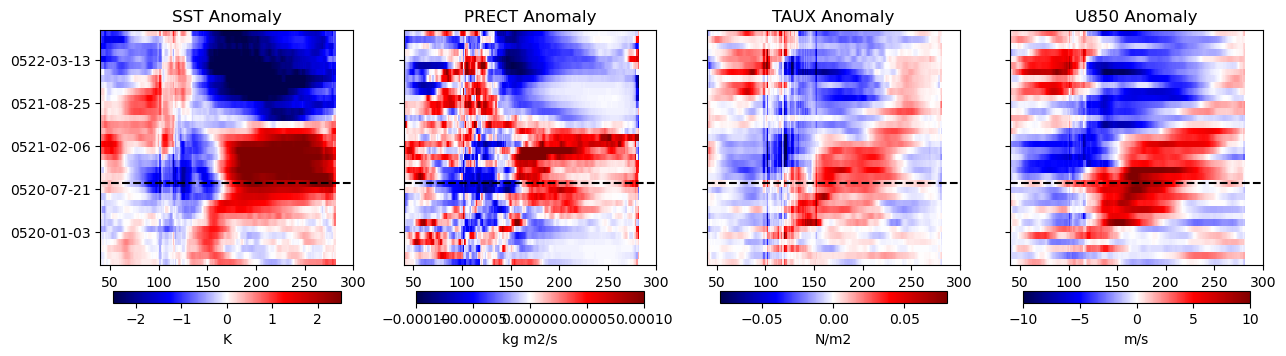

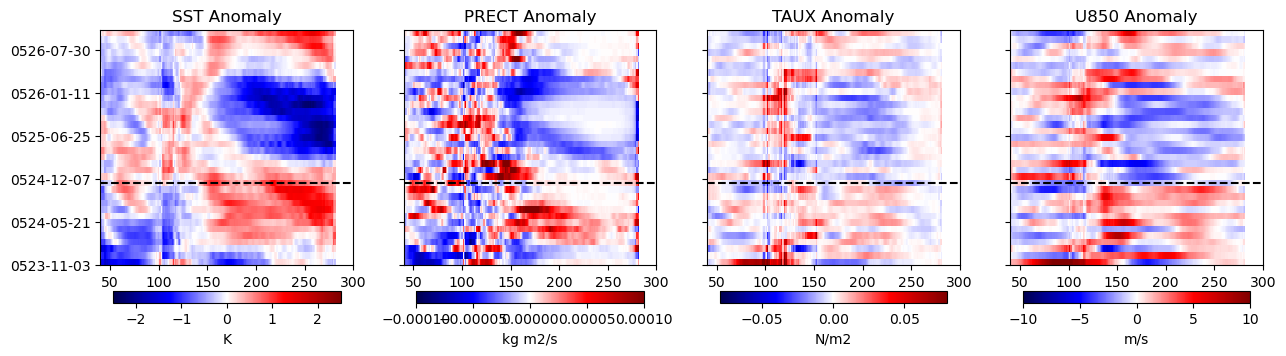

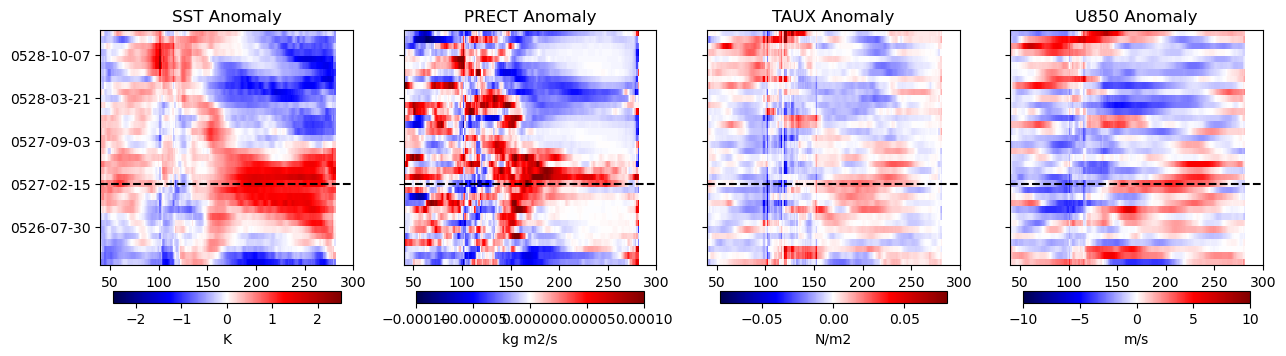

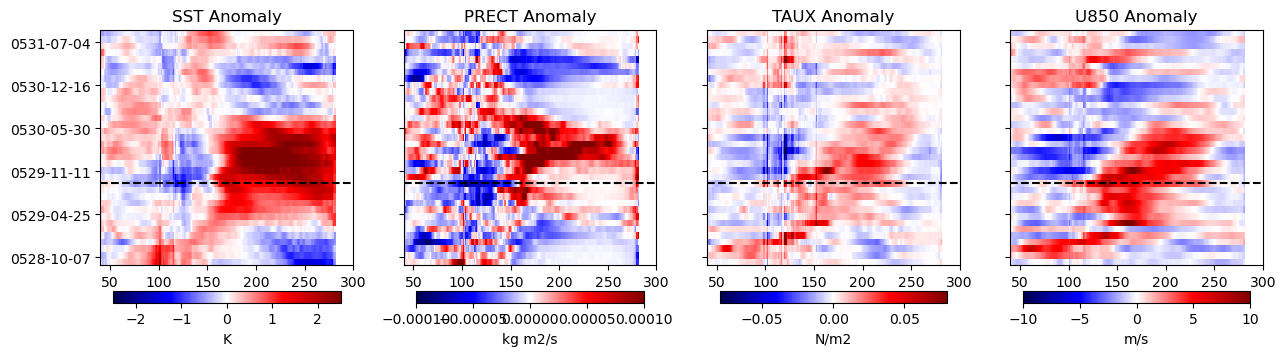

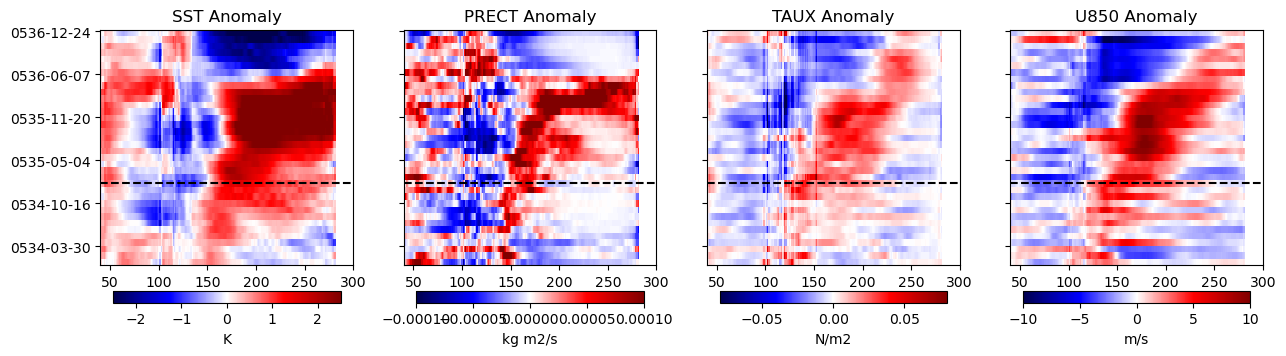

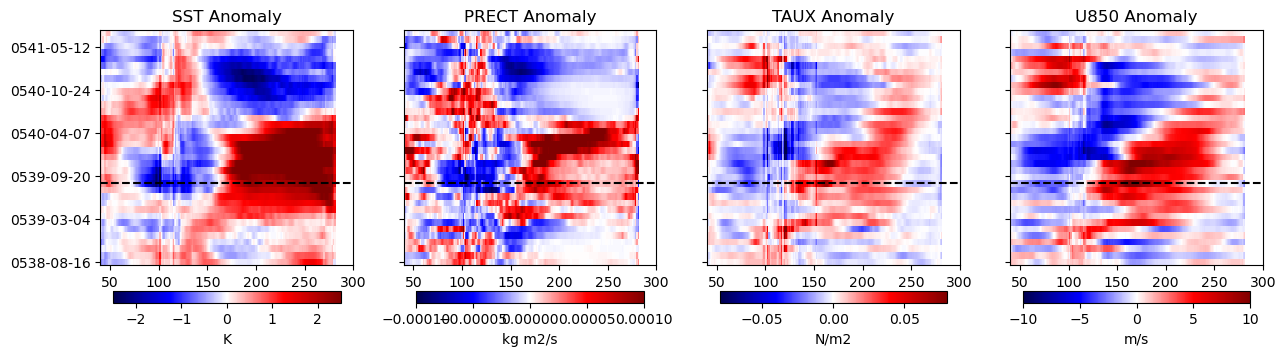

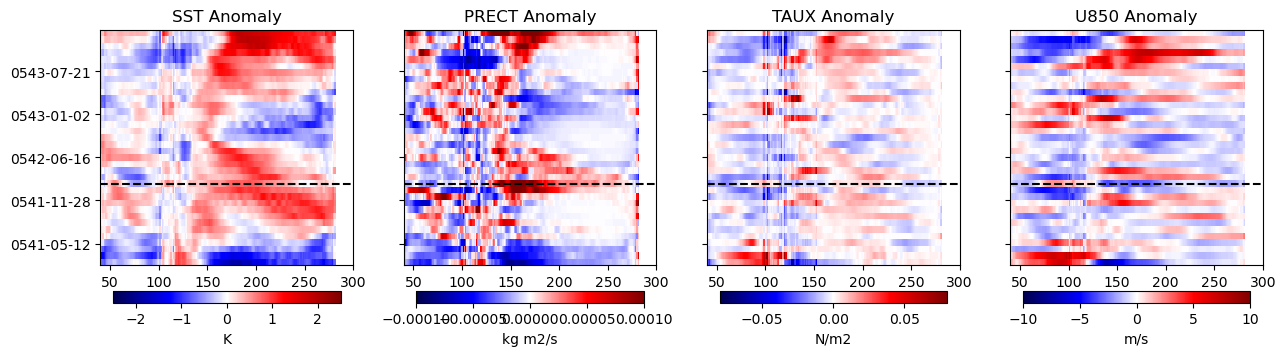

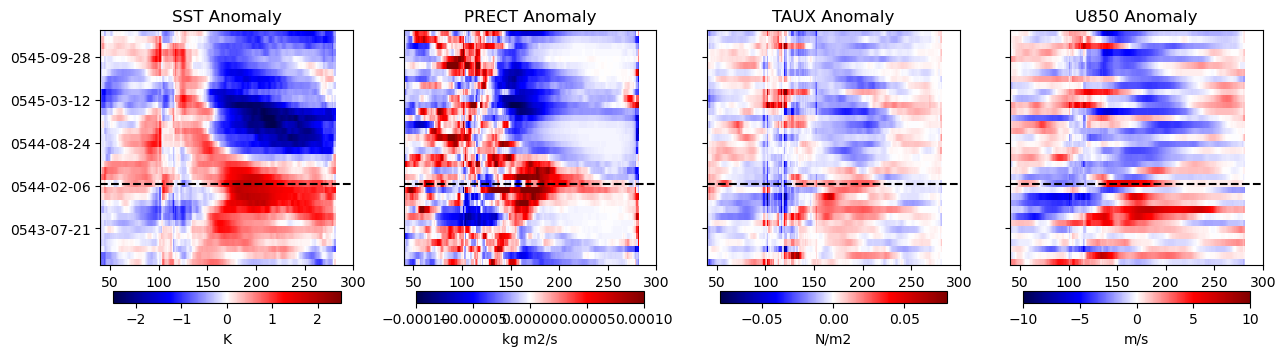

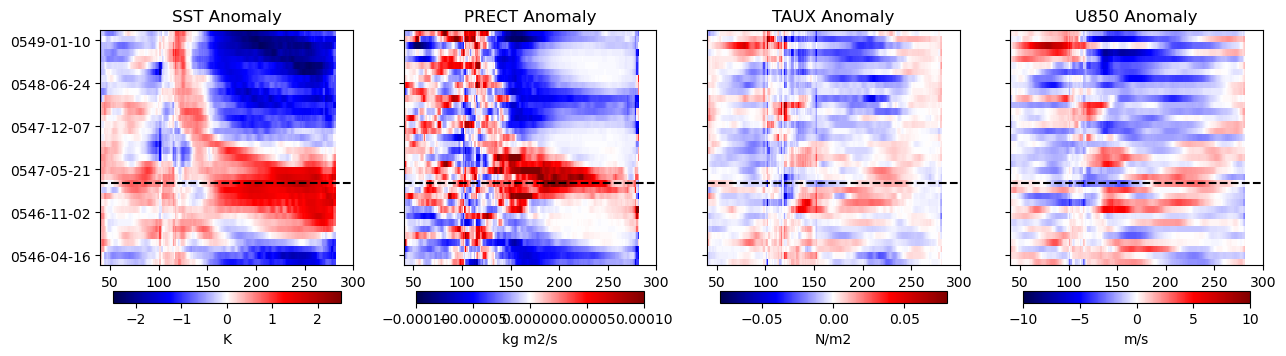

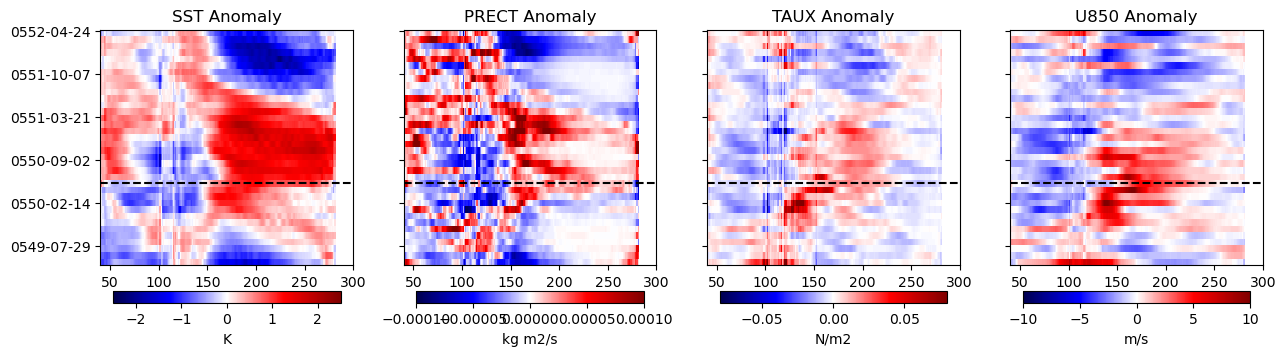

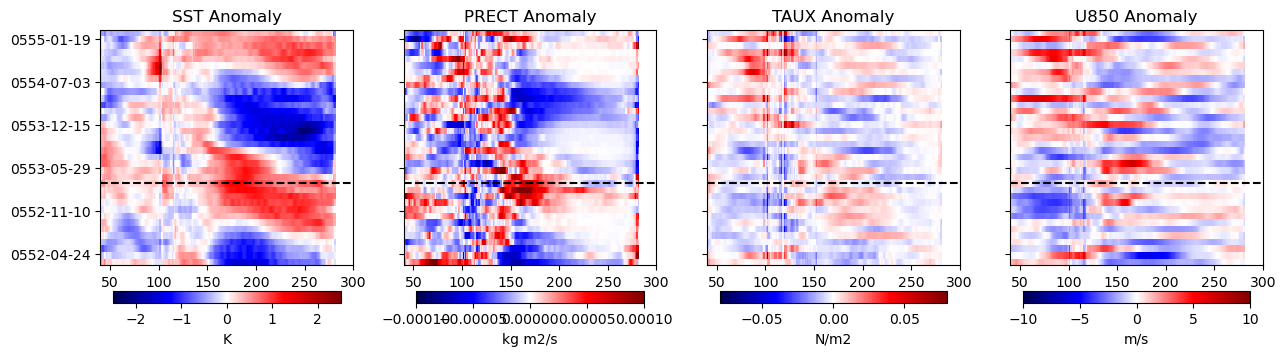

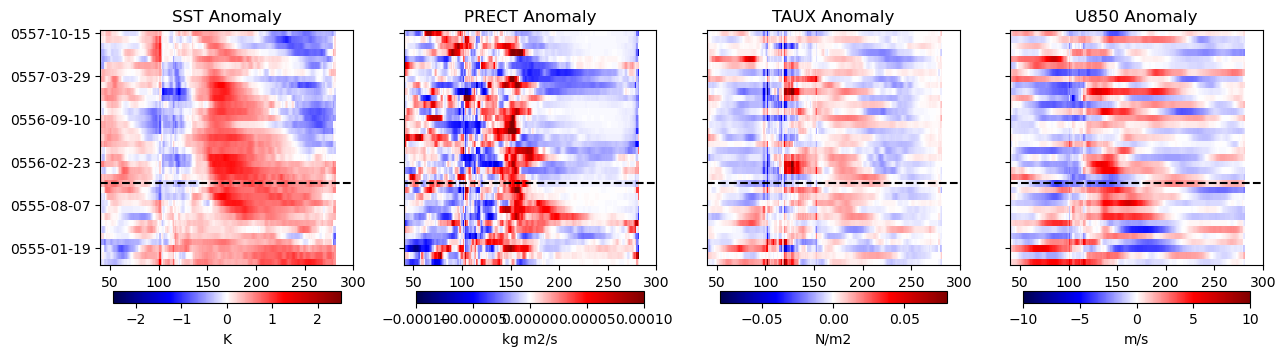

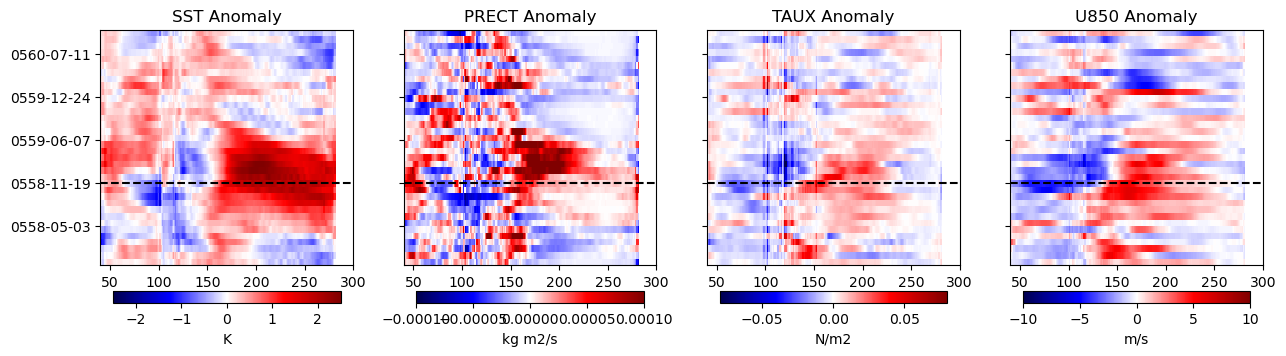

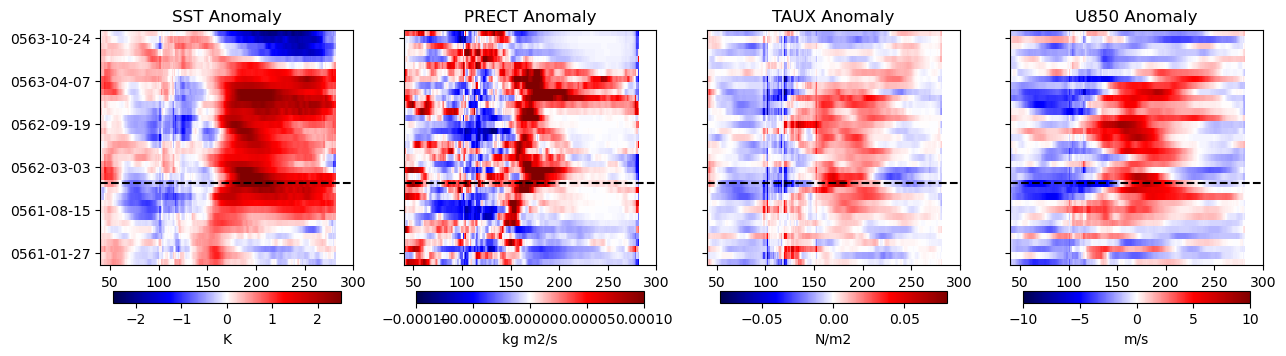

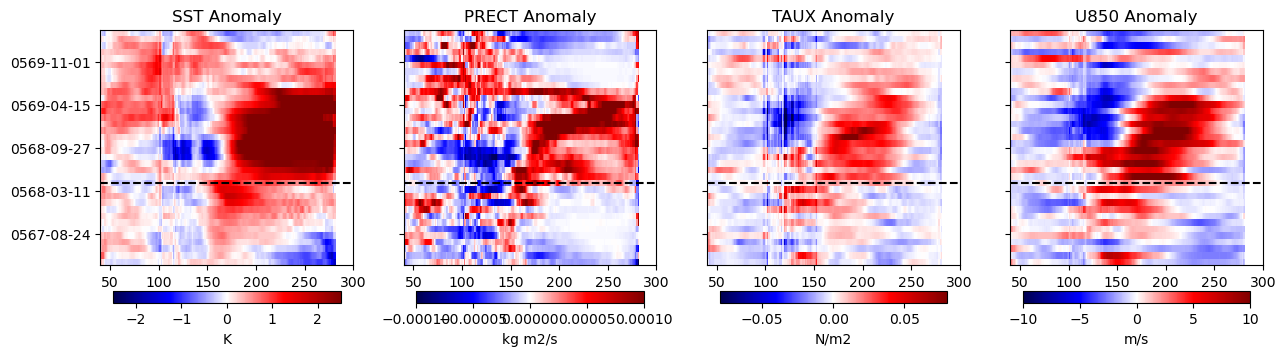

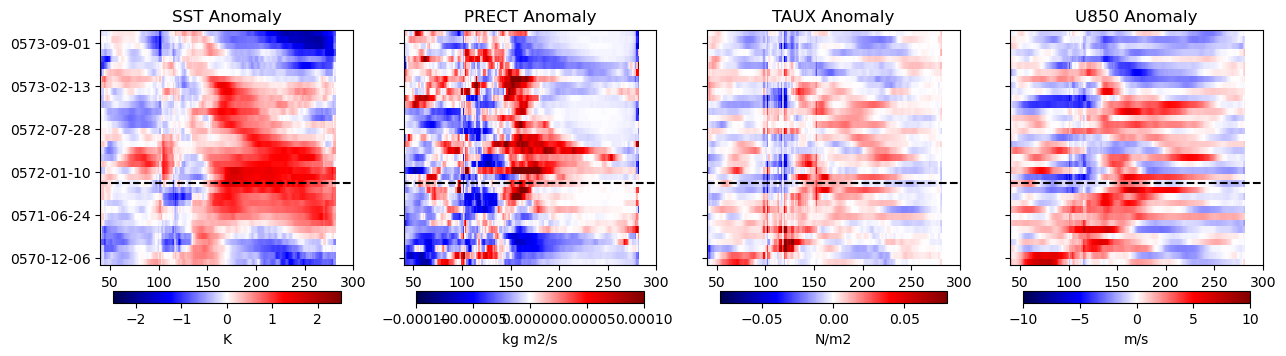

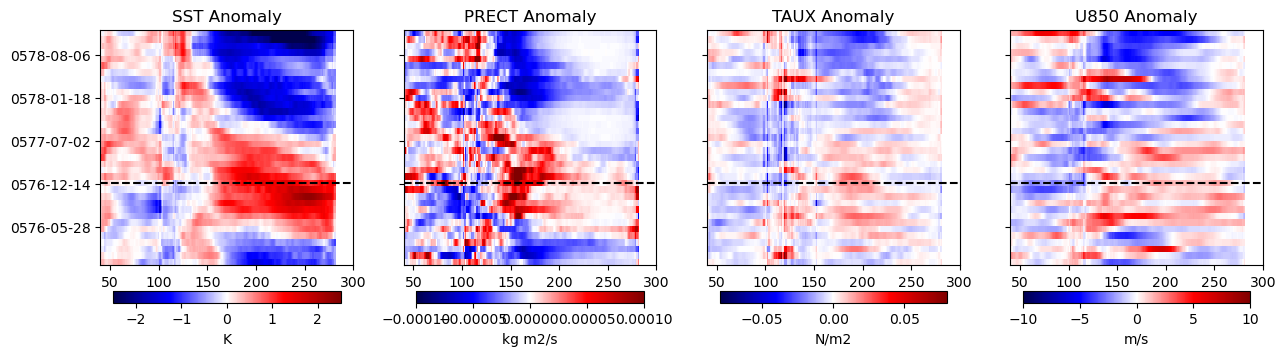

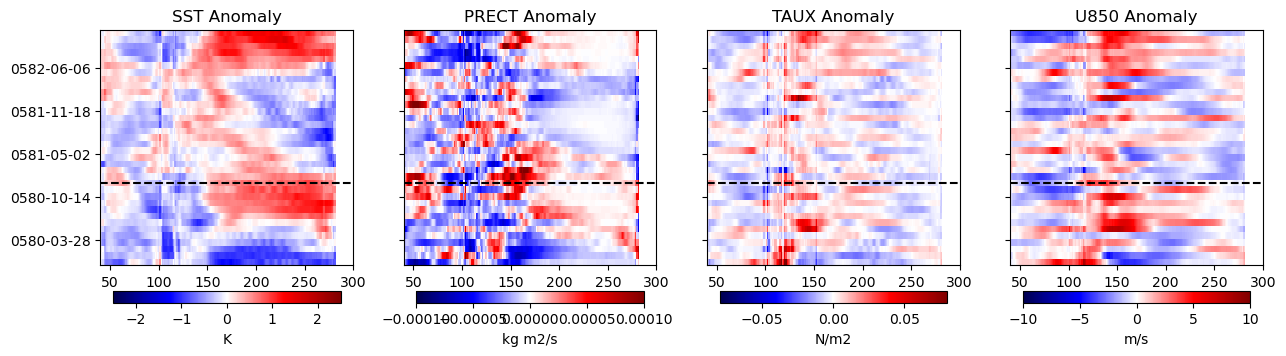

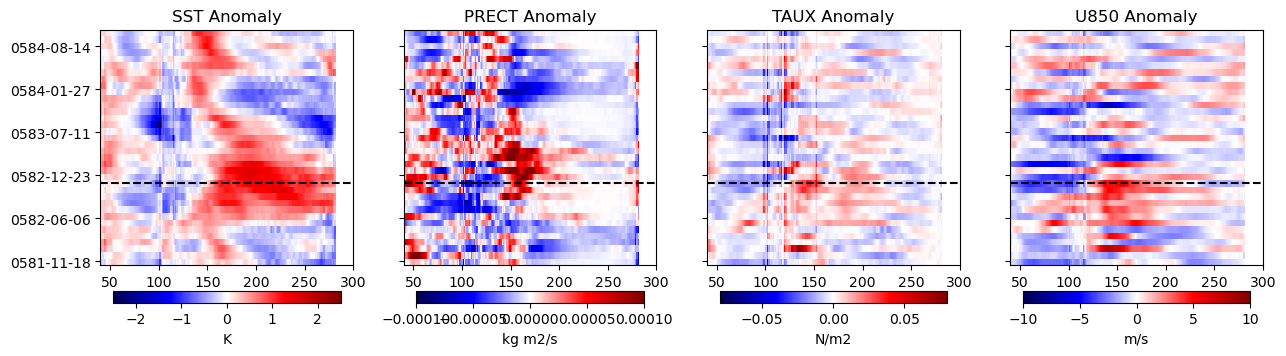

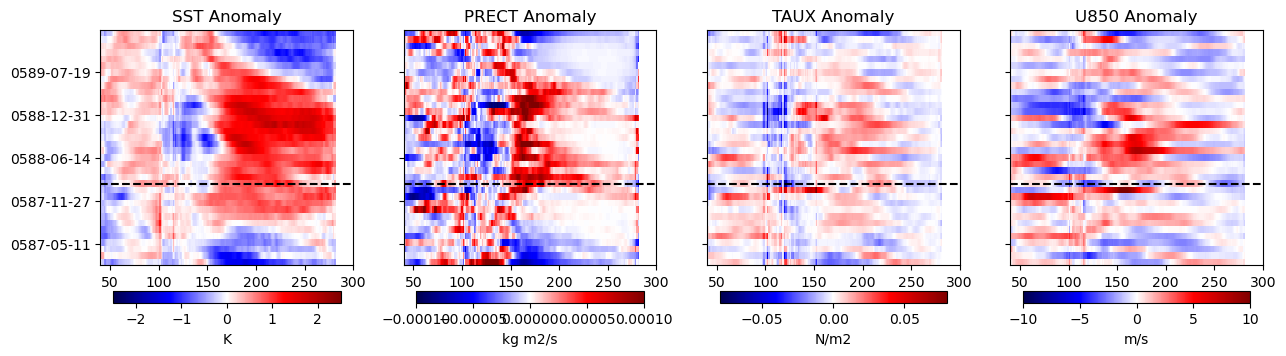

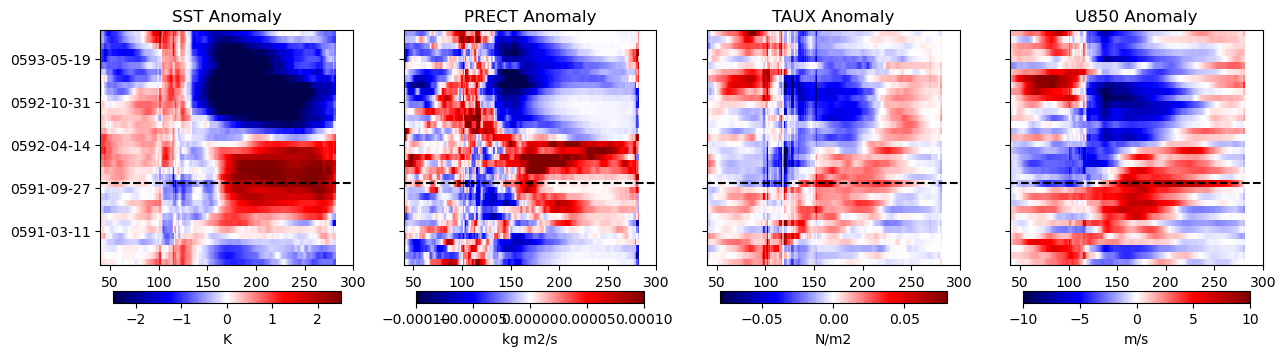

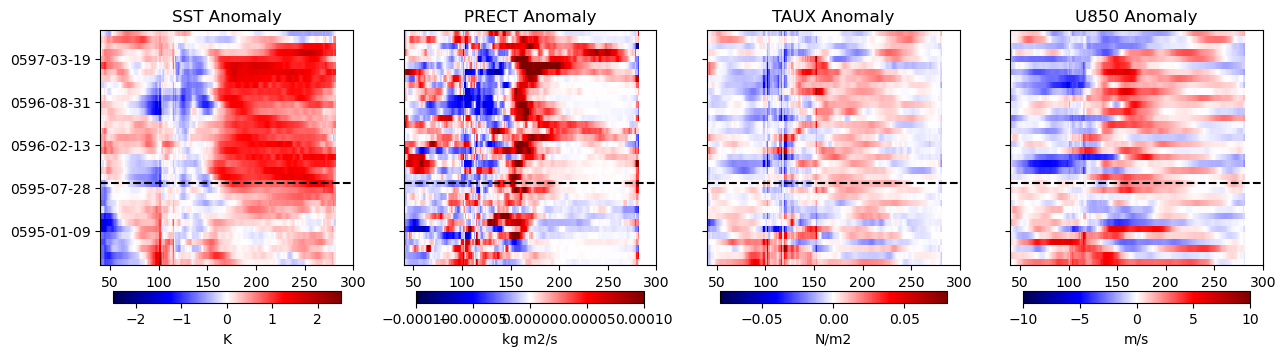

In [101]:

normVar_SST   = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)
normVar_TAUX  = matplotlib.colors.Normalize(vmin=-0.08,vmax=0.08)
normVar_PRECT = matplotlib.colors.Normalize(vmin=-1e-4,vmax=1e-4)
normVar_U850  = matplotlib.colors.Normalize(vmin=-10,vmax=10)

for iElNino in range(len(startInd_cesm2)): 
    fig,axs=plt.subplots(1,4,figsize=(15,4))
    axs = axs.ravel()

    time_nums = matplotlib.dates.date2num(sst_cesm2_latAvg.isel(time=slice(startInd_cesm2[iElNino]-12,(startInd_cesm2[iElNino]+24)))['time'].values)
    longrid,tgrid  = np.meshgrid(sst_cesm2_latAvg['lon'], time_nums )

    p1 = axs[0].pcolormesh(longrid,tgrid, sst_cesm2_latAvg.isel(time=slice(startInd_cesm2[iElNino]-12,(startInd_cesm2[iElNino]+24))),
                  norm=normVar_SST, cmap='seismic')
    axs[0].set_title('SST Anomaly')
    axs[0].yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d')) 

    p2 = axs[1].pcolormesh(longrid,tgrid, prect_cesm2_latAvg.isel(time=slice(startInd_cesm2[iElNino]-12,(startInd_cesm2[iElNino]+24))),
                  norm=normVar_PRECT, cmap='seismic')
    axs[1].set_title('PRECT Anomaly')
    axs[1].set_yticklabels([])

    p3 = axs[2].pcolormesh(longrid,tgrid, taux_cesm2_latAvg.isel(time=slice(startInd_cesm2[iElNino]-12,(startInd_cesm2[iElNino]+24))),
                  norm=normVar_TAUX, cmap='seismic')
    axs[2].set_title('TAUX Anomaly')
    axs[2].set_yticklabels([])

    p4 = axs[3].pcolormesh(longrid,tgrid, u850_cesm2_latAvg.isel(time=slice(startInd_cesm2[iElNino]-12,(startInd_cesm2[iElNino]+24))),
                  norm=normVar_U850, cmap='seismic')
    axs[3].set_title('U850 Anomaly')
    axs[3].set_yticklabels([])

    
    [a.set_xlim([40,300]) for a in axs]
    startDateNum =  matplotlib.dates.date2num(sst_cesm2_latAvg.isel(time=startInd_cesm2[iElNino])['time'].values)
    [a.axhline(startDateNum, color='k', linestyle='--')  for a in axs]
    # [a.yaxis.set_major_formatter(matplotlib.dates.DateFormatter('%04Y-%m-%d')) for a in axs]
    
    # Add Colorbars
    cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_SST, cmap='seismic'), ax=axs[0], 
                       shrink=0.9, label='K', orientation='horizontal', pad=0.085) 
    cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_PRECT, cmap='seismic'), ax=axs[1], 
                       shrink=0.9, label='kg m2/s', orientation='horizontal', pad=0.085) 
    cb3 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_TAUX, cmap='seismic'), ax=axs[2], 
                       shrink=0.9, label='N/m2', orientation='horizontal', pad=0.085)
    cb4 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar_U850, cmap='seismic'), ax=axs[3], 
                       shrink=0.9, label='m/s', orientation='horizontal', pad=0.085)


    fig.savefig('Figures/Hovs/CESM2_ENSOvars_hov_startDate'+str(sst_cesm2_latAvg.isel(time=startInd_cesm2[iElNino])['time.year'].values)+str(sst_cesm2_latAvg.isel(time=startInd_cesm2[iElNino])['time.month'].values)+'.jpg')
